<a href="https://colab.research.google.com/github/shinbad/can_bus/blob/ANN/CAN_ANN_Timediff_20240702.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Google Drive Mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 데이터 전처리  
- 각 ID별로 Timediff 값 추가
- 몇 ID가 test데이터에 공격데이터의 수가 부족해 테스트가 안되는 문제가 발생
- 따라서 디코딩 과정에서 데이터 수가 너무 많아 split했던 data들을 각 ID별로 concat해서 데이터의 양을 늘림


---  
**<데이터 크기로 인한 split 과정>**  
Pre_train_D_1 ->
  - decoded_can_data_AddDLC_1_0 ->
      - /filtered_data_AddDLC_1_0/pre_train_D_1_0_ID_{id}   (총 56개)
  - decoded_can_data_AddDLC_1_1 ->
      - /filtered_data_AddDLC_1_1/pre_train_D_1_1_ID_{id}   (총 56개)

Pre_train_D_2 ->
  - decoded_can_data_AddDLC_2_0 ->
      - /filtered_data_AddDLC_2_0/pre_train_D_2_0_ID_{id}   (총 56개)
  - decoded_can_data_AddDLC_2_1 ->
      - /filtered_data_AddDLC_2_1/pre_train_D_2_1_ID_{id}   (총 56개)

=> 총 224개의 파일 생성

**<학습을 위한 concat과정>**   
 동일한 id  
combined_df ->
 - pre_train_D_**1_0**_ID_{id} + pre_train_D_**1_1**_ID_{id} + pre_train_D_**2_0**_ID_{id} + pre_train_D_**2_1**_ID_{id}

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

# 주어진 ID 리스트
ids = ['251', '2B0', '381', '340', '260', '47F', '329', '164', '387', '394',
       '4F1', '130', '140', '356', '153', '220', '367', '368', '412',
       '470', '38D', '420', '421', '389', '386', '492', '391', '485', '490',
       '593', '484', '48A', '50C', '58B', '436', '541', '507', '4A7', '520',
       '53E', '495', '500', '483', '4A2', '50A', '043', '52A', '544',
       '559', '410', '07F', '57F', '5B0']

       # 366, 563, 553

# 빈도수 분포; ID 별 메시지 TimeDelta 값(ms)
can_freqs = {'000': 2.0,
      '043': 1.0, '07F': 1.0, '130': 0.01, '140': 0.01, '153': 0.01, '164': 0.01, '220': 0.01, '251': 0.01,
      '260': 0.01, '2B0': 0.01, '329': 0.01, '340': 0.01, '356': 0.01, '366': 0.01, '367': 0.01, '368': 0.01, '381': 0.02,
      '386': 0.02, '387': 0.02, '389': 0.02, '38D': 0.02, '391': 0.02, '394': 0.02, '410': 0.2, '412': 0.2, '420': 0.02,
      '421': 0.02, '42D': 0.1, '436': 0.05, '44E': 0.2, '453': 0.02, '470': 0.02, '479': 0.1, '47F': 0.02, '483': 0.2,
      '484': 0.07, '485': 0.05, '48A': 0.05, '48C': 0.2, '490': 0.05, '492': 0.05, '495': 0.1, '49F': 0.2, '4A2': 0.5,
      '4A4': 2.0, '4A7': 0.5, '4A9': 0.2, '4C9': 0.2, '4CB': 0.2, '4F1': 0.02, '500': 0.1, '507': 0.1, '50A': 0.2,
      '50C': 0.1, '50E': 0.2, '520': 0.1, '52A': 0.2, '53B': 0.2, '53E': 0.1, '53F': 0.2, '541': 0.1, '544': 0.2,
      '553': 0.2, '559': 0.2, '563': 0.5, '568': 0.1, '572': 0.2, '57F': 1.5, '58B': 0.05, '593': 0.2, '5A6': 0.2,
      '5B0': 1.0, '5BE': 1.0, '5CD': 0.2, '7C4': 2.0, '7CC': 2.0, '7D0': 2.0, '7D4': 2.0, '7D8': 2.0, '7DC': 2.0 }

In [ ]:
# 데이터 프레임을 저장할 딕셔너리 생성
dfs_by_id_train = {}

# 반복문을 통해 각 ID에 대해 데이터 로드 및 전처리 후 결합하여 딕셔너리에 추가
for id in ids:
    id_dfs = []
    for folder_number in range(1, 3):  # 2개의 폴더를 처리할 것으로 가정
        for j in range(2):  # ID가 0과 1인 두 가지 경우를 처리할 것으로 가정
            file_path = f'/content/drive/MyDrive/CAN/Decoding_data_Timediff_20240627/H-SCOPE/filtered_data_AddDLC_{folder_number}_{j}/pre_train_D_{folder_number}_{j}_ID_{id}.csv'
            try:
                df = pd.read_csv(file_path)
                id_dfs.append(df)
            except FileNotFoundError:
                print(f'File not found: {file_path}')

    if id_dfs:  # id_dfs 리스트가 비어 있지 않은 경우에만 concat
        combined_df = pd.concat(id_dfs, ignore_index=True)

        # TimeDiff 컬럼 추가
        # diff() : 현재 행과 이전 행 차이 계산(timestamp)
        # fillna() : 첫번째 행의 경우 이전행이 없으므로 can_freqs[id]를 이용하여 계산한다.
        combined_df['TimeDiff1'] = ((combined_df['Timestamp'].diff().fillna(can_freqs[id])))
        combined_df['TimeDiff2'] = ((combined_df['Timestamp'].diff(periods=2).fillna(can_freqs[id]*2)))
        combined_df['TimeDiff3'] = ((combined_df['Timestamp'].diff(periods=3).fillna(can_freqs[id]*3)))
        combined_df['TimeDiff4'] = ((combined_df['Timestamp'].diff(periods=4).fillna(can_freqs[id]*4)))
        combined_df['TimeDiff5'] = ((combined_df['Timestamp'].diff(periods=5).fillna(can_freqs[id]*5)))
        combined_df['TimeDiff6'] = ((combined_df['Timestamp'].diff(periods=6).fillna(can_freqs[id]*6)))

        # 객체 타입 컬럼을 카테고리 타입으로 변환
        for col in combined_df.columns:
            if combined_df[col].dtype == 'object':
                combined_df[col] = combined_df[col].astype('category')

        # 모든 값이 0인 경우 제외
        if (combined_df.drop(['Timestamp', 'Arbitration_ID', 'SubClass', 'DLC'], axis=1) == 0).all().all():
            print(f"ID {id}는 모든 값이 0이므로 제외합니다.")
        else:
            dfs_by_id_train[f'df_{id}_combined'] = combined_df

In [ ]:
dfs_by_id_train['df_260_combined']

,Timestamp,Arbitration_ID,SubClass,DLC,Checksum,TQI_MIN,TQI,TQI_TARGET,GLOW_STAT,CRUISE_LAMP_M,...,TQI_MAX,SPK_TIME_CUR,AliveCounter,CF_Ems_AclAct,TimeDiff1,TimeDiff2,TimeDiff3,TimeDiff4,TimeDiff5,TimeDiff6
0,0.007005,260,Normal,8,9.0,1.953125,20.312500,0.781250,0.0,0.0,...,73.4375,-2.25,1.0,0.0,0.010000,0.020000,0.030000,0.040000,0.050000,0.060000
1,0.016660,260,Normal,8,8.0,1.953125,20.312500,0.781250,0.0,0.0,...,73.4375,-2.25,2.0,0.0,0.009655,0.020000,0.030000,0.040000,0.050000,0.060000
2,0.026868,260,Normal,8,7.0,1.953125,20.312500,0.781250,0.0,0.0,...,73.4375,-2.25,3.0,0.0,0.010208,0.019863,0.030000,0.040000,0.050000,0.060000
3,0.036675,260,Normal,8,10.0,1.953125,20.312500,0.781250,0.0,0.0,...,73.4375,-2.25,0.0,0.0,0.009807,0.020015,0.029670,0.040000,0.050000,0.060000
4,0.046681,260,Normal,8,9.0,1.953125,20.312500,0.781250,0.0,0.0,...,73.4375,-2.25,1.0,0.0,0.010006,0.019813,0.030021,0.039676,0.050000,0.060000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66119,167.399959,260,Normal,8,7.0,1.953125,16.796875,0.000000,0.0,0.0,...,73.4375,-3.00,1.0,0.0,0.010692,0.019379,0.030830,0.040898,0.050214,0.060771
66120,167.409276,260,Normal,8,6.0,1.953125,16.796875,0.000000,0.0,0.0,...,73.4375,-3.00,2.0,0.0,0.009317,0.020009,0.028696,0.040147,0.050215,0.059531
66121,167.419839,260,Normal,8,5.0,1.953125,16.796875,0.000000,0.0,0.0,...,73.4375,-3.00,3.0,0.0,0.010563,0.019880,0.030572,0.039259,0.050710,0.060778
66122,167.429246,260,Normal,8,7.0,1.953125,16.796875,0.390625,0.0,0.0,...,73.4375,-3.00,0.0,0.0,0.009407,0.019970,0.029287,0.039979,0.048666,0.060117


In [ ]:
# 데이터 프레임을 저장할 딕셔너리 생성
dfs_by_id_test = {}

# 반복문을 통해 각 ID에 대해 데이터 로드 및 전처리 후 결합하여 딕셔너리에 추가
for id in ids:
    id_dfs = []
    for i in range(0,6):  # 2개의 폴더를 처리할 것으로 가정
        file_path = f'/content/drive/MyDrive/CAN/submit_filter_data/D{i}/pre_test_D_{i}_ID_{id}.csv'
        try:
            df = pd.read_csv(file_path)
            id_dfs.append(df)
        except FileNotFoundError:
            print(f'File not found: {file_path}')

    if id_dfs:  # id_dfs 리스트가 비어 있지 않은 경우에만 concat
        combined_df = pd.concat(id_dfs, ignore_index=True)

        # TimeDiff 컬럼 추가
        # diff() : 현재 행과 이전 행 차이 계산(timestamp)
        # fillna() : 첫번째 행의 경우 이전행이 없으므로 can_freqs[id]를 이용하여 계산한다.
        combined_df['TimeDiff1'] = ((combined_df['Timestamp'].diff().fillna(can_freqs[id])))
        combined_df['TimeDiff2'] = ((combined_df['Timestamp'].diff(periods=2).fillna(can_freqs[id]*2)))
        combined_df['TimeDiff3'] = ((combined_df['Timestamp'].diff(periods=3).fillna(can_freqs[id]*3)))
        combined_df['TimeDiff4'] = ((combined_df['Timestamp'].diff(periods=4).fillna(can_freqs[id]*4)))
        combined_df['TimeDiff5'] = ((combined_df['Timestamp'].diff(periods=5).fillna(can_freqs[id]*5)))
        combined_df['TimeDiff6'] = ((combined_df['Timestamp'].diff(periods=6).fillna(can_freqs[id]*6)))

        # 객체 타입 컬럼을 카테고리 타입으로 변환
        for col in combined_df.columns:
            if combined_df[col].dtype == 'object':
                combined_df[col] = combined_df[col].astype('category')

        # 모든 값이 0인 경우 제외
        if (combined_df.drop(['Timestamp', 'Arbitration_ID', 'SubClass', 'DLC'], axis=1) == 0).all().all():
            print(f"ID {id}는 모든 값이 0이므로 제외합니다.")
        else:
            dfs_by_id_test[f'df_{id}_combined'] = combined_df

In [ ]:
dfs_by_id_test['df_260_combined']

,Timestamp,Arbitration_ID,SubClass,DLC,TQI_MIN,TQI,TQI_TARGET,GLOW_STAT,CRUISE_LAMP_M,CRUISE_LAMP_S,...,SPK_TIME_CUR,Checksum,AliveCounter,CF_Ems_AclAct,TimeDiff1,TimeDiff2,TimeDiff3,TimeDiff4,TimeDiff5,TimeDiff6
0,0.000457,260,Normal,8,1.953125,14.843750,0.390625,0.0,0.0,0.0,...,-3.0,11.0,2.0,0.0,0.010000,0.020000,0.030000,0.040000,0.050000,0.060000
1,0.010557,260,Normal,8,1.953125,14.843750,0.390625,0.0,0.0,0.0,...,-3.0,10.0,3.0,0.0,0.010100,0.020000,0.030000,0.040000,0.050000,0.060000
2,0.020474,260,Normal,8,1.953125,14.843750,0.390625,0.0,0.0,0.0,...,-3.0,13.0,0.0,0.0,0.009917,0.020017,0.030000,0.040000,0.050000,0.060000
3,0.030472,260,Normal,8,1.953125,14.843750,0.390625,0.0,0.0,0.0,...,-3.0,12.0,1.0,0.0,0.009998,0.019915,0.030015,0.040000,0.050000,0.060000
4,0.040468,260,Normal,8,1.953125,14.843750,0.390625,0.0,0.0,0.0,...,-3.0,11.0,2.0,0.0,0.009996,0.019994,0.029911,0.040011,0.050000,0.060000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77215,96.745680,260,Normal,8,1.953125,18.359375,3.906250,0.0,0.0,0.0,...,-6.0,14.0,2.0,0.0,0.010021,0.020041,0.029986,0.040020,0.049973,0.060064
77216,96.755736,260,Normal,8,1.953125,18.359375,3.906250,0.0,0.0,0.0,...,-6.0,13.0,3.0,0.0,0.010056,0.020077,0.030097,0.040042,0.050076,0.060029
77217,96.765635,260,Normal,8,1.953125,18.359375,3.906250,0.0,0.0,0.0,...,-6.0,0.0,0.0,0.0,0.009899,0.019955,0.029976,0.039996,0.049941,0.059975
77218,96.775676,260,Normal,8,1.953125,18.359375,3.906250,0.0,0.0,0.0,...,-6.0,15.0,1.0,0.0,0.010041,0.019940,0.029996,0.040017,0.050037,0.059982


In [ ]:
dfs_by_id_test['df_260_combined'].iloc[:,-6:]

,TimeDiff1,TimeDiff2,TimeDiff3,TimeDiff4,TimeDiff5,TimeDiff6
0,0.010000,0.020000,0.030000,0.040000,0.050000,0.060000
1,0.010100,0.020000,0.030000,0.040000,0.050000,0.060000
2,0.009917,0.020017,0.030000,0.040000,0.050000,0.060000
3,0.009998,0.019915,0.030015,0.040000,0.050000,0.060000
4,0.009996,0.019994,0.029911,0.040011,0.050000,0.060000
...,...,...,...,...,...,...
77215,0.010021,0.020041,0.029986,0.040020,0.049973,0.060064
77216,0.010056,0.020077,0.030097,0.040042,0.050076,0.060029
77217,0.009899,0.019955,0.029976,0.039996,0.049941,0.059975
77218,0.010041,0.019940,0.029996,0.040017,0.050037,0.059982


## 학습, 테스트 데이터 split & 모델 학습

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping

In [ ]:
# id별 학습 및 테스트 셋
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

def id_train_test_set(dfs_by_id_train, dfs_by_id_test, data_id):
    # 데이터프레임 선택
    df_combined_train = dfs_by_id_train[f'df_{data_id}_combined']
    df_combined_test = dfs_by_id_test[f'df_{data_id}_combined']

    train_columns = df_combined_train.columns

    df_combined_test = df_combined_test[train_columns]


    # 타겟 변수와 특징 변수 분리
    X_train = df_combined_train.drop(['SubClass', 'Arbitration_ID'], axis=1)
    y_train = df_combined_train['SubClass']

    X_test = df_combined_test.drop(['SubClass', 'Arbitration_ID'], axis=1)
    y_test = df_combined_test['SubClass']

    categorical_columns = X_train.select_dtypes(include=['category']).columns
    X_train = pd.get_dummies(X_train, columns=categorical_columns)

    categorical_columns = X_test.select_dtypes(include=['category']).columns
    X_test = pd.get_dummies(X_test, columns=categorical_columns)

    cols = X_train.columns
    # 정규화
    scaler = MinMaxScaler()
    X_train.iloc[:,1:-6] = scaler.fit_transform(X_train.iloc[:,1:-6])
    X_train_scaler = X_train.iloc[:,1:-6].astype(np.float32)

    X_test.iloc[:,1:-6] = scaler.transform(X_test.iloc[:,1:-6])
    X_test_scaler = X_test.iloc[:,1:-6].astype(np.float32)

    X_train_df=pd.DataFrame(X_train_scaler, columns=cols)
    X_test_df=pd.DataFrame(X_test_scaler, columns=cols)

    # 클래스 레이블을 숫자로 인코딩
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)


    return X_train_scaler, X_test_scaler, y_train_encoded, y_test_encoded, label_encoder.classes_

In [ ]:
def model_train(X_train_ex, X_test_ex, y_train_encoded, y_test_encoded, class_labels):
    # 조기 종료
    early_stopping = EarlyStopping(
          monitor='val_loss',
          patience=5,
          restore_best_weights=True
      )

    # 모델 구축(LSTM)
    #model1
    initializer = "glorot_uniform"
    constraints = None

    model = tf.keras.Sequential([
      tf.keras.layers.Dense(64, input_dim=X_train_ex.shape[1], kernel_initializer=initializer, bias_initializer="zeros", kernel_constraint=constraints, activation='relu'),
      tf.keras.layers.Dense(128, input_dim=X_train_ex.shape[1], kernel_initializer=initializer, bias_initializer="zeros", kernel_constraint=constraints,activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(128, input_dim=X_train_ex.shape[1], kernel_initializer=initializer, bias_initializer="zeros", kernel_constraint=constraints,activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(64, input_dim=X_train_ex.shape[1], kernel_initializer=initializer, bias_initializer="zeros", kernel_constraint=constraints,activation='relu'),
      tf.keras.layers.Dense(len(class_labels),activation='softmax')
      ])

    # 모델 컴파일
    model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
    # 모델 학습
    training_record = model.fit(X_train_ex, y_train_encoded, epochs=100, batch_size=128,
                                validation_split=0.3, callbacks=[early_stopping],verbose=1, shuffle=False)

    pred = model.predict(X_test_ex)   # 예측
    y_pred = pred.argmax(axis=1)

    # Learning Curve 시각화
    fig, ax = plt.subplots()
    plt.plot(training_record.history["loss"], label="Training Loss")
    plt.plot(training_record.history["val_loss"], label="Validation Loss")
    plt.legend()
    fig.suptitle("Loss")
    plt.show()

    return y_pred

## 모델 성능 평가

###All ID accuracy test

Processing ID: 251
Epoch 1/100
362/362 [==============================] - 3s 6ms/step - loss: 0.1812 - accuracy: 0.9765 - val_loss: 0.1061 - val_accuracy: 0.9802
Epoch 2/100
362/362 [==============================] - 2s 5ms/step - loss: 0.1170 - accuracy: 0.9855 - val_loss: 0.0975 - val_accuracy: 0.9805
Epoch 3/100
362/362 [==============================] - 2s 5ms/step - loss: 0.1017 - accuracy: 0.9856 - val_loss: 0.0961 - val_accuracy: 0.9808
Epoch 4/100
362/362 [==============================] - 3s 8ms/step - loss: 0.0973 - accuracy: 0.9858 - val_loss: 0.0964 - val_accuracy: 0.9809
Epoch 5/100
362/362 [==============================] - 2s 7ms/step - loss: 0.1010 - accuracy: 0.9857 - val_loss: 0.0965 - val_accuracy: 0.9809
Epoch 6/100
362/362 [==============================] - 2s 5ms/step - loss: 0.0944 - accuracy: 0.9859 - val_loss: 0.0955 - val_accuracy: 0.9809
Epoch 7/100
362/362 [==============================] - 2s 5ms/step - loss: 0.0969 - accuracy: 0.9859 - val_loss: 0.0958 - v

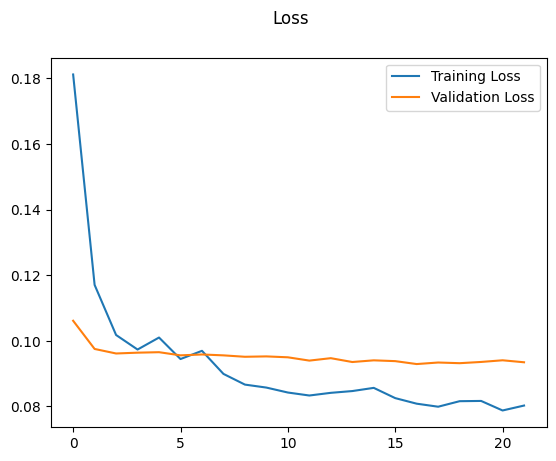

Result:

     Accuracy  F1 Score  Precision    Recall
251  0.979334  0.659547   0.992085  0.660457

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.98      0.99      1076
      Normal       0.98      1.00      0.99     74723
      Replay       0.00      0.00      0.00      1576

    accuracy                           0.98     77375
   macro avg       0.66      0.66      0.66     77375
weighted avg       0.96      0.98      0.97     77375



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


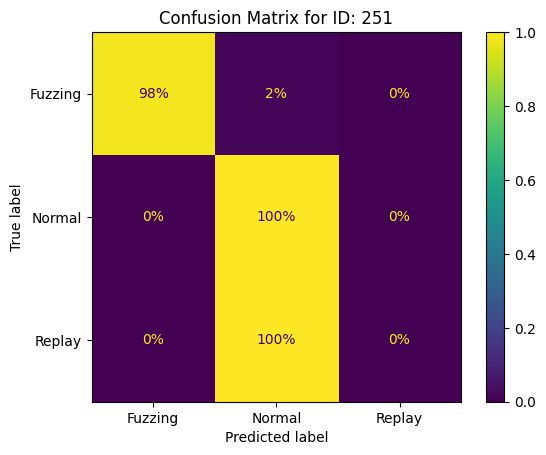

<Figure size 800x600 with 0 Axes>





Processing ID: 2B0
Epoch 1/100
362/362 [==============================] - 4s 8ms/step - loss: 0.1938 - accuracy: 0.9744 - val_loss: 0.1065 - val_accuracy: 0.9816
Epoch 2/100
362/362 [==============================] - 2s 5ms/step - loss: 0.1153 - accuracy: 0.9865 - val_loss: 0.0929 - val_accuracy: 0.9816
Epoch 3/100
362/362 [==============================] - 2s 5ms/step - loss: 0.1082 - accuracy: 0.9865 - val_loss: 0.0929 - val_accuracy: 0.9816
Epoch 4/100
362/362 [==============================] - 2s 5ms/step - loss: 0.1172 - accuracy: 0.9865 - val_loss: 0.0936 - val_accuracy: 0.9816
Epoch 5/100
362/362 [==============================] - 2s 5ms/step - loss: 0.1086 - accuracy: 0.9864 - val_loss: 0.0931 - val_accuracy: 0.9816
Epoch 6/100
362/362 [==============================] - 2s 5ms/step - loss: 0.0906 - accuracy: 0.9865 - val_loss: 0.0931 - val_accuracy: 0.9816
Epoch 7/100
362/362 [==============================] - 3s 9ms/step - loss: 0.0881 - accuracy: 0.9865 - val_loss: 0.0930

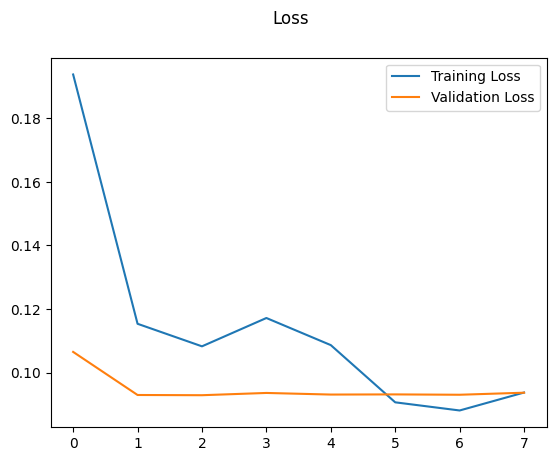

Result:

     Accuracy  F1 Score  Precision    Recall
2B0  0.979616  0.663187   0.993112  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00      1043
      Normal       0.98      1.00      0.99     74696
      Replay       0.00      0.00      0.00      1576

    accuracy                           0.98     77315
   macro avg       0.66      0.67      0.66     77315
weighted avg       0.96      0.98      0.97     77315



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


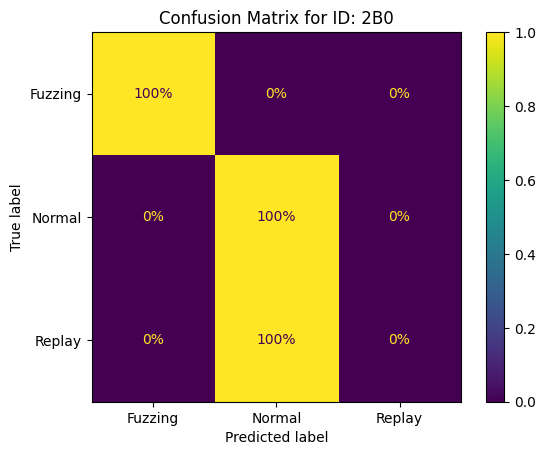

<Figure size 800x600 with 0 Axes>





Processing ID: 381
Epoch 1/100
181/181 [==============================] - 4s 11ms/step - loss: 0.2395 - accuracy: 0.9699 - val_loss: 0.1119 - val_accuracy: 0.9809
Epoch 2/100
181/181 [==============================] - 2s 9ms/step - loss: 0.1112 - accuracy: 0.9863 - val_loss: 0.0999 - val_accuracy: 0.9816
Epoch 3/100
181/181 [==============================] - 1s 6ms/step - loss: 0.1047 - accuracy: 0.9865 - val_loss: 0.1002 - val_accuracy: 0.9816
Epoch 4/100
181/181 [==============================] - 1s 7ms/step - loss: 0.0985 - accuracy: 0.9865 - val_loss: 0.0982 - val_accuracy: 0.9817
Epoch 5/100
181/181 [==============================] - 1s 7ms/step - loss: 0.0989 - accuracy: 0.9865 - val_loss: 0.0977 - val_accuracy: 0.9816
Epoch 6/100
181/181 [==============================] - 1s 7ms/step - loss: 0.0936 - accuracy: 0.9865 - val_loss: 0.0959 - val_accuracy: 0.9817
Epoch 7/100
181/181 [==============================] - 1s 6ms/step - loss: 0.0925 - accuracy: 0.9865 - val_loss: 0.095

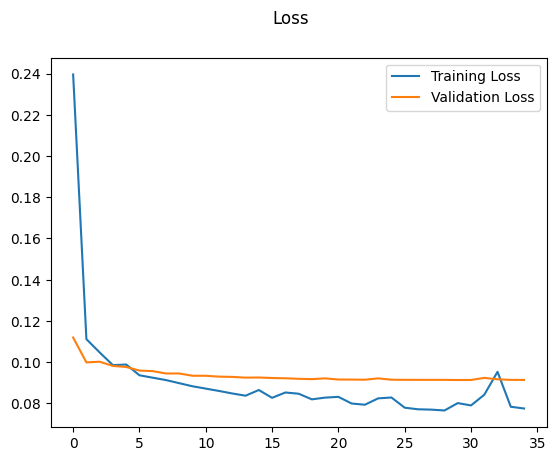

Result:

     Accuracy  F1 Score  Precision    Recall
381  0.979563  0.662539   0.993095  0.665392

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       523
      Normal       0.98      1.00      0.99     37344
      Replay       0.00      0.00      0.00       788

    accuracy                           0.98     38655
   macro avg       0.66      0.67      0.66     38655
weighted avg       0.96      0.98      0.97     38655



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


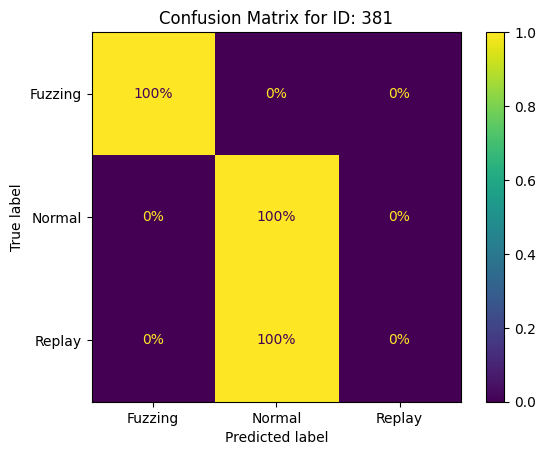

<Figure size 800x600 with 0 Axes>





Processing ID: 340
Epoch 1/100
360/360 [==============================] - 4s 7ms/step - loss: 0.1448 - accuracy: 0.9758 - val_loss: 0.1117 - val_accuracy: 0.9812
Epoch 2/100
360/360 [==============================] - 2s 6ms/step - loss: 0.0935 - accuracy: 0.9863 - val_loss: 0.1043 - val_accuracy: 0.9814
Epoch 3/100
360/360 [==============================] - 2s 7ms/step - loss: 0.0850 - accuracy: 0.9863 - val_loss: 0.0876 - val_accuracy: 0.9815
Epoch 4/100
360/360 [==============================] - 2s 5ms/step - loss: 0.0849 - accuracy: 0.9864 - val_loss: 0.0906 - val_accuracy: 0.9814
Epoch 5/100
360/360 [==============================] - 2s 7ms/step - loss: 0.0792 - accuracy: 0.9864 - val_loss: 0.0869 - val_accuracy: 0.9815
Epoch 6/100
360/360 [==============================] - 3s 9ms/step - loss: 0.0722 - accuracy: 0.9864 - val_loss: 0.0874 - val_accuracy: 0.9814
Epoch 7/100
360/360 [==============================] - 2s 6ms/step - loss: 0.0685 - accuracy: 0.9864 - val_loss: 0.0869

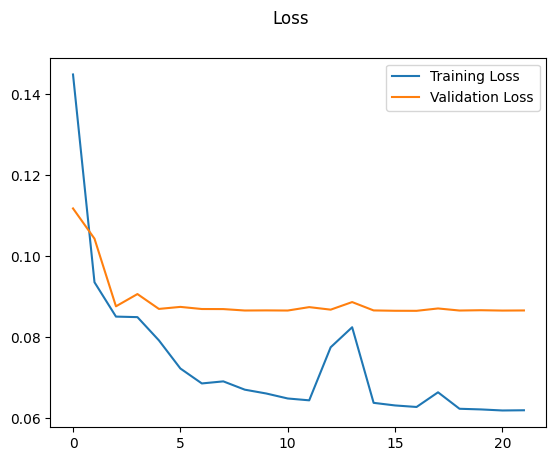

Result:

     Accuracy  F1 Score  Precision    Recall
340  0.979482  0.663188   0.993115  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       506
      Normal       0.98      1.00      0.99     74679
      Replay       0.00      0.00      0.00      1575

    accuracy                           0.98     76760
   macro avg       0.66      0.67      0.66     76760
weighted avg       0.96      0.98      0.97     76760



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


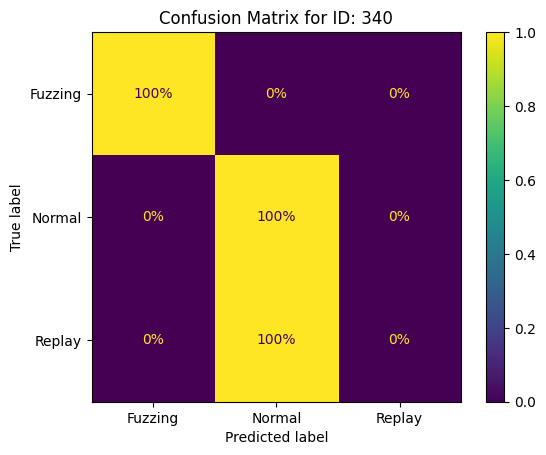

<Figure size 800x600 with 0 Axes>





Processing ID: 260
Epoch 1/100
362/362 [==============================] - 3s 6ms/step - loss: 0.1069 - accuracy: 0.9739 - val_loss: 0.0213 - val_accuracy: 0.9816
Epoch 2/100
362/362 [==============================] - 2s 5ms/step - loss: 0.0112 - accuracy: 0.9933 - val_loss: 6.2523e-04 - val_accuracy: 1.0000
Epoch 3/100
362/362 [==============================] - 2s 5ms/step - loss: 5.7813e-04 - accuracy: 0.9999 - val_loss: 2.6940e-05 - val_accuracy: 1.0000
Epoch 4/100
362/362 [==============================] - 3s 8ms/step - loss: 1.9009e-04 - accuracy: 1.0000 - val_loss: 2.3916e-04 - val_accuracy: 0.9999
Epoch 5/100
362/362 [==============================] - 3s 8ms/step - loss: 2.3777e-05 - accuracy: 1.0000 - val_loss: 8.6156e-05 - val_accuracy: 0.9999
Epoch 6/100
362/362 [==============================] - 2s 6ms/step - loss: 1.8563e-05 - accuracy: 1.0000 - val_loss: 8.1610e-06 - val_accuracy: 1.0000
Epoch 7/100
362/362 [==============================] - 2s 5ms/step - loss: 8.5026e-

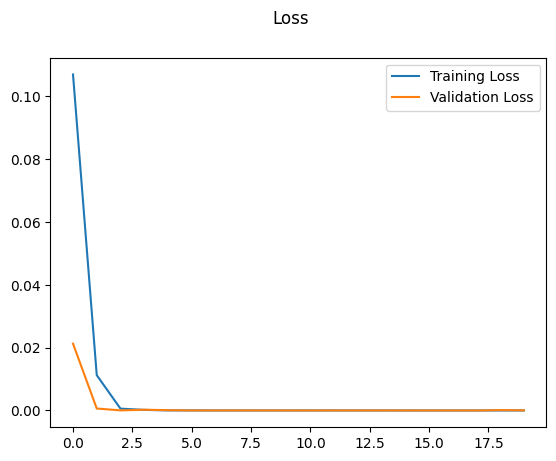

Result:

     Accuracy  F1 Score  Precision    Recall
260  0.999987  0.999826   0.999996  0.999656

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       970
      Normal       1.00      1.00      1.00     74673
      Replay       1.00      1.00      1.00      1577

    accuracy                           1.00     77220
   macro avg       1.00      1.00      1.00     77220
weighted avg       1.00      1.00      1.00     77220



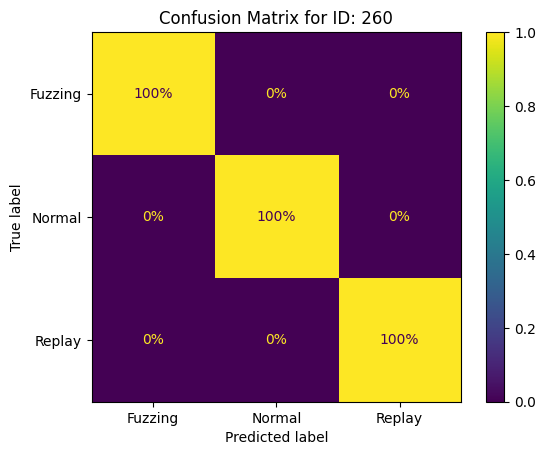

<Figure size 800x600 with 0 Axes>





Processing ID: 47F
Epoch 1/100
181/181 [==============================] - 3s 11ms/step - loss: 0.2191 - accuracy: 0.9558 - val_loss: 0.1206 - val_accuracy: 0.9743
Epoch 2/100
181/181 [==============================] - 2s 9ms/step - loss: 0.0942 - accuracy: 0.9854 - val_loss: 0.0950 - val_accuracy: 0.9815
Epoch 3/100
181/181 [==============================] - 1s 6ms/step - loss: 0.0803 - accuracy: 0.9863 - val_loss: 0.0915 - val_accuracy: 0.9817
Epoch 4/100
181/181 [==============================] - 1s 6ms/step - loss: 0.0740 - accuracy: 0.9865 - val_loss: 0.0880 - val_accuracy: 0.9817
Epoch 5/100
181/181 [==============================] - 1s 5ms/step - loss: 0.0831 - accuracy: 0.9866 - val_loss: 0.0900 - val_accuracy: 0.9817
Epoch 6/100
181/181 [==============================] - 1s 5ms/step - loss: 0.0750 - accuracy: 0.9865 - val_loss: 0.0882 - val_accuracy: 0.9817
Epoch 7/100
181/181 [==============================] - 1s 6ms/step - loss: 0.0706 - accuracy: 0.9866 - val_loss: 0.086

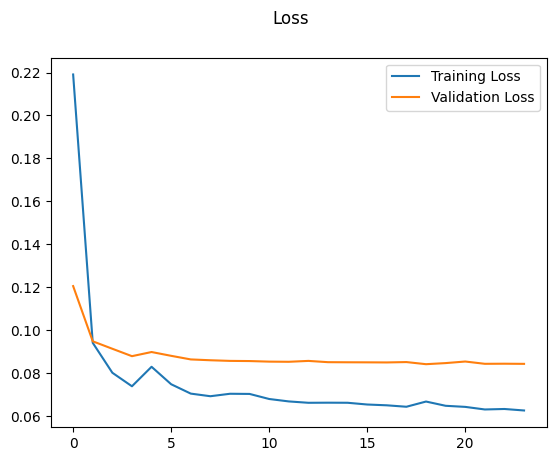

Result:

     Accuracy  F1 Score  Precision    Recall
47F  0.979557  0.662517   0.993096  0.665347

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       505
      Normal       0.98      1.00      0.99     37351
      Replay       0.00      0.00      0.00       788

    accuracy                           0.98     38644
   macro avg       0.66      0.67      0.66     38644
weighted avg       0.96      0.98      0.97     38644



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


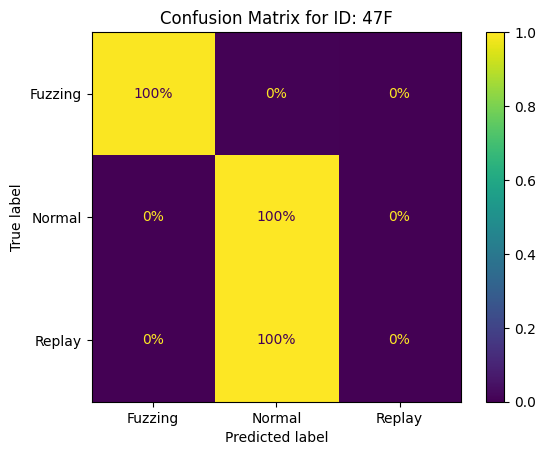

<Figure size 800x600 with 0 Axes>





Processing ID: 329
Epoch 1/100
360/360 [==============================] - 3s 6ms/step - loss: 0.1750 - accuracy: 0.9746 - val_loss: 0.1084 - val_accuracy: 0.9814
Epoch 2/100
360/360 [==============================] - 2s 5ms/step - loss: 0.1135 - accuracy: 0.9863 - val_loss: 0.0933 - val_accuracy: 0.9814
Epoch 3/100
360/360 [==============================] - 2s 6ms/step - loss: 0.0987 - accuracy: 0.9864 - val_loss: 0.0914 - val_accuracy: 0.9814
Epoch 4/100
360/360 [==============================] - 3s 7ms/step - loss: 0.0932 - accuracy: 0.9864 - val_loss: 0.0918 - val_accuracy: 0.9814
Epoch 5/100
360/360 [==============================] - 3s 9ms/step - loss: 0.0991 - accuracy: 0.9864 - val_loss: 0.0917 - val_accuracy: 0.9813
Epoch 6/100
360/360 [==============================] - 2s 6ms/step - loss: 0.0952 - accuracy: 0.9864 - val_loss: 0.0900 - val_accuracy: 0.9814
Epoch 7/100
360/360 [==============================] - 2s 6ms/step - loss: 0.0871 - accuracy: 0.9864 - val_loss: 0.0892

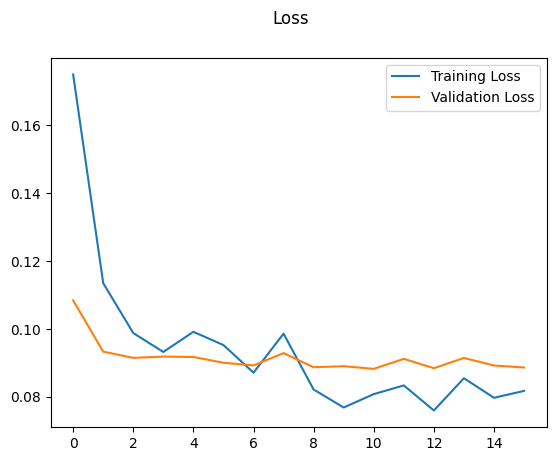

Result:

     Accuracy  F1 Score  Precision    Recall
329  0.979399  0.661867   0.993087  0.664062

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.99      1.00       512
      Normal       0.98      1.00      0.99     74655
      Replay       0.00      0.00      0.00      1577

    accuracy                           0.98     76744
   macro avg       0.66      0.66      0.66     76744
weighted avg       0.96      0.98      0.97     76744



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


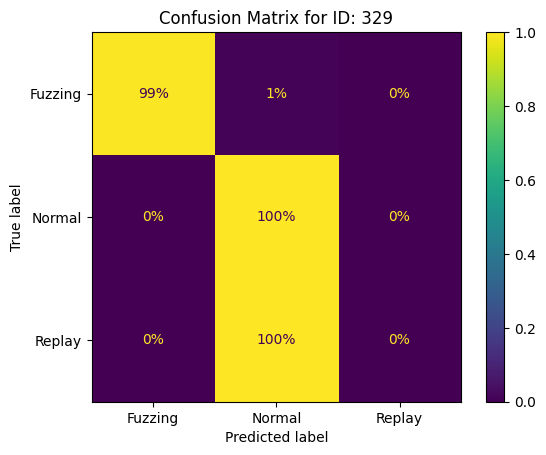

<Figure size 800x600 with 0 Axes>





Processing ID: 164
Epoch 1/100
362/362 [==============================] - 3s 6ms/step - loss: 0.1930 - accuracy: 0.9531 - val_loss: 0.1148 - val_accuracy: 0.9640
Epoch 2/100
362/362 [==============================] - 2s 5ms/step - loss: 0.0973 - accuracy: 0.9792 - val_loss: 0.0890 - val_accuracy: 0.9816
Epoch 3/100
362/362 [==============================] - 2s 5ms/step - loss: 0.0770 - accuracy: 0.9865 - val_loss: 0.0879 - val_accuracy: 0.9816
Epoch 4/100
362/362 [==============================] - 2s 5ms/step - loss: 0.0769 - accuracy: 0.9865 - val_loss: 0.0855 - val_accuracy: 0.9816
Epoch 5/100
362/362 [==============================] - 3s 8ms/step - loss: 0.0732 - accuracy: 0.9865 - val_loss: 0.0849 - val_accuracy: 0.9816
Epoch 6/100
362/362 [==============================] - 3s 9ms/step - loss: 0.0783 - accuracy: 0.9865 - val_loss: 0.0849 - val_accuracy: 0.9816
Epoch 7/100
362/362 [==============================] - 2s 6ms/step - loss: 0.0741 - accuracy: 0.9865 - val_loss: 0.0846

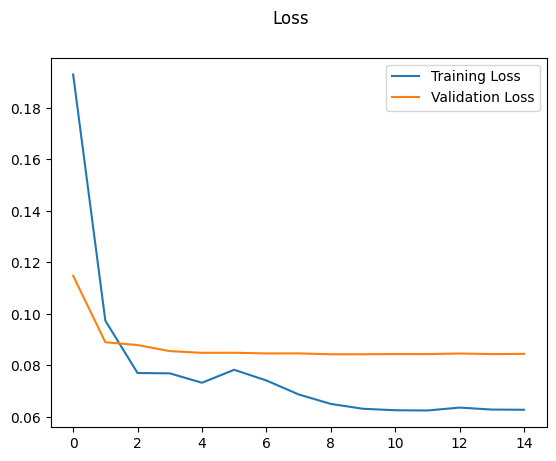

Result:

     Accuracy  F1 Score  Precision    Recall
164  0.979612  0.663187   0.993113  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00      1023
      Normal       0.98      1.00      0.99     74700
      Replay       0.00      0.00      0.00      1576

    accuracy                           0.98     77299
   macro avg       0.66      0.67      0.66     77299
weighted avg       0.96      0.98      0.97     77299



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


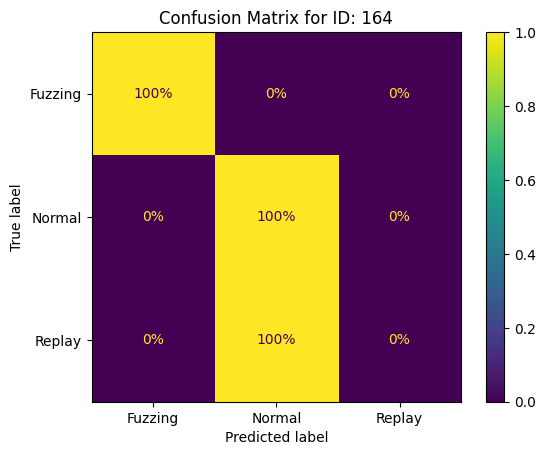

<Figure size 800x600 with 0 Axes>





Processing ID: 387
Epoch 1/100
182/182 [==============================] - 2s 7ms/step - loss: 0.2620 - accuracy: 0.9626 - val_loss: 0.1380 - val_accuracy: 0.9631
Epoch 2/100
182/182 [==============================] - 1s 7ms/step - loss: 0.1017 - accuracy: 0.9807 - val_loss: 0.0895 - val_accuracy: 0.9811
Epoch 3/100
182/182 [==============================] - 1s 6ms/step - loss: 0.0698 - accuracy: 0.9860 - val_loss: 0.0864 - val_accuracy: 0.9811
Epoch 4/100
182/182 [==============================] - 1s 7ms/step - loss: 0.0584 - accuracy: 0.9860 - val_loss: 0.0801 - val_accuracy: 0.9812
Epoch 5/100
182/182 [==============================] - 2s 9ms/step - loss: 0.0554 - accuracy: 0.9861 - val_loss: 0.0776 - val_accuracy: 0.9811
Epoch 6/100
182/182 [==============================] - 2s 9ms/step - loss: 0.0515 - accuracy: 0.9861 - val_loss: 0.0727 - val_accuracy: 0.9812
Epoch 7/100
182/182 [==============================] - 2s 9ms/step - loss: 0.0494 - accuracy: 0.9861 - val_loss: 0.0678

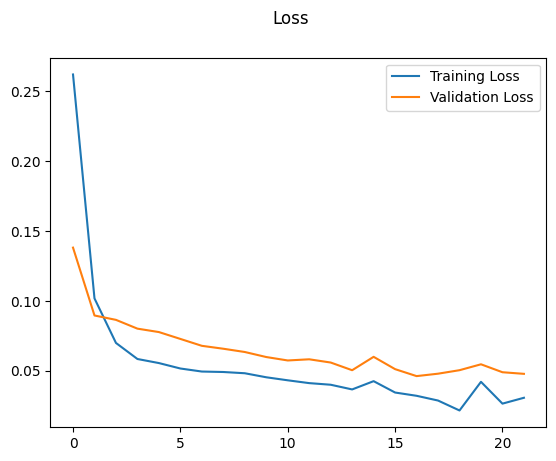

Result:

     Accuracy  F1 Score  Precision    Recall
387  0.976477  0.741338   0.780321  0.721368

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.99      0.99       512
      Normal       0.98      0.99      0.99     37300
      Replay       0.36      0.18      0.24       788

    accuracy                           0.98     38600
   macro avg       0.78      0.72      0.74     38600
weighted avg       0.97      0.98      0.97     38600



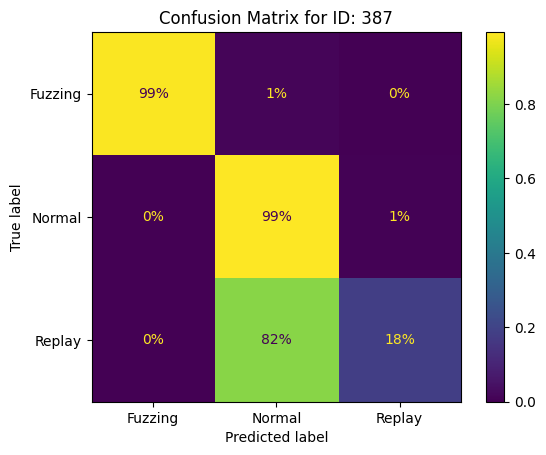

<Figure size 800x600 with 0 Axes>





Processing ID: 394
Epoch 1/100
181/181 [==============================] - 2s 8ms/step - loss: 0.2013 - accuracy: 0.9625 - val_loss: 0.0915 - val_accuracy: 0.9811
Epoch 2/100
181/181 [==============================] - 1s 6ms/step - loss: 0.0868 - accuracy: 0.9840 - val_loss: 0.0709 - val_accuracy: 0.9816
Epoch 3/100
181/181 [==============================] - 1s 6ms/step - loss: 0.0590 - accuracy: 0.9864 - val_loss: 0.0498 - val_accuracy: 0.9816
Epoch 4/100
181/181 [==============================] - 1s 6ms/step - loss: 0.0444 - accuracy: 0.9864 - val_loss: 0.0416 - val_accuracy: 0.9817
Epoch 5/100
181/181 [==============================] - 1s 7ms/step - loss: 0.0394 - accuracy: 0.9864 - val_loss: 0.0384 - val_accuracy: 0.9817
Epoch 6/100
181/181 [==============================] - 2s 9ms/step - loss: 0.0364 - accuracy: 0.9864 - val_loss: 0.0370 - val_accuracy: 0.9817
Epoch 7/100
181/181 [==============================] - 2s 9ms/step - loss: 0.0308 - accuracy: 0.9864 - val_loss: 0.0513

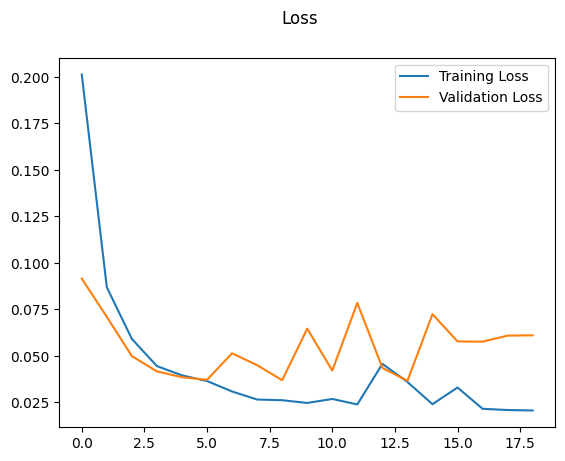

Result:

     Accuracy  F1 Score  Precision    Recall
394  0.979538  0.662811   0.993099  0.665929

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       452
      Normal       0.98      1.00      0.99     37319
      Replay       0.00      0.00      0.00       788

    accuracy                           0.98     38559
   macro avg       0.66      0.67      0.66     38559
weighted avg       0.96      0.98      0.97     38559



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


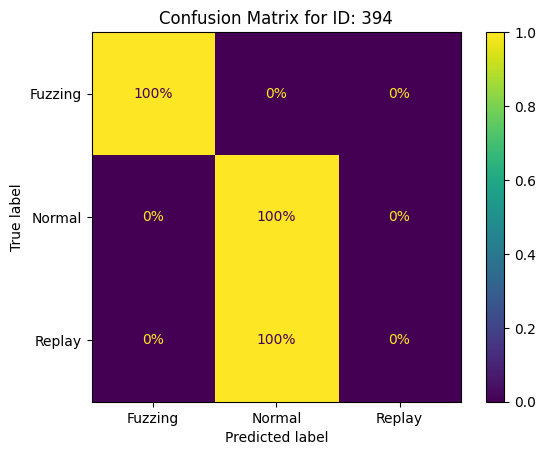

<Figure size 800x600 with 0 Axes>





Processing ID: 4F1
Epoch 1/100
181/181 [==============================] - 2s 7ms/step - loss: 0.2447 - accuracy: 0.9647 - val_loss: 0.1130 - val_accuracy: 0.9758
Epoch 2/100
181/181 [==============================] - 1s 6ms/step - loss: 0.0928 - accuracy: 0.9857 - val_loss: 0.0906 - val_accuracy: 0.9816
Epoch 3/100
181/181 [==============================] - 1s 6ms/step - loss: 0.0851 - accuracy: 0.9865 - val_loss: 0.0904 - val_accuracy: 0.9815
Epoch 4/100
181/181 [==============================] - 1s 6ms/step - loss: 0.0781 - accuracy: 0.9864 - val_loss: 0.0918 - val_accuracy: 0.9816
Epoch 5/100
181/181 [==============================] - 1s 6ms/step - loss: 0.0789 - accuracy: 0.9864 - val_loss: 0.0938 - val_accuracy: 0.9816
Epoch 6/100
181/181 [==============================] - 2s 9ms/step - loss: 0.0708 - accuracy: 0.9864 - val_loss: 0.0962 - val_accuracy: 0.9816
Epoch 7/100
181/181 [==============================] - 2s 9ms/step - loss: 0.0693 - accuracy: 0.9865 - val_loss: 0.0983

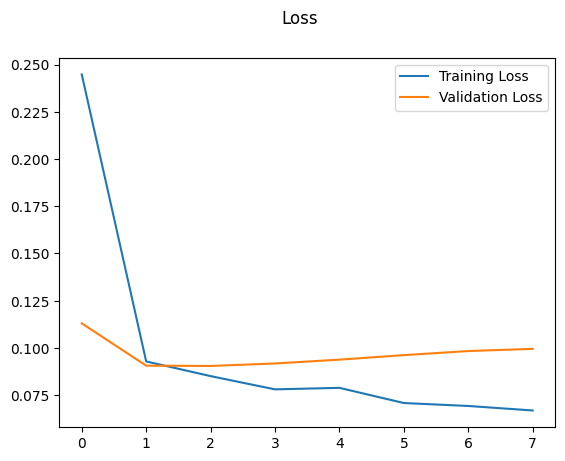

Result:

     Accuracy  F1 Score  Precision    Recall
4F1  0.979436  0.661422    0.99306  0.663209

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.99      0.99       482
      Normal       0.98      1.00      0.99     37293
      Replay       0.00      0.00      0.00       788

    accuracy                           0.98     38563
   macro avg       0.66      0.66      0.66     38563
weighted avg       0.96      0.98      0.97     38563



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


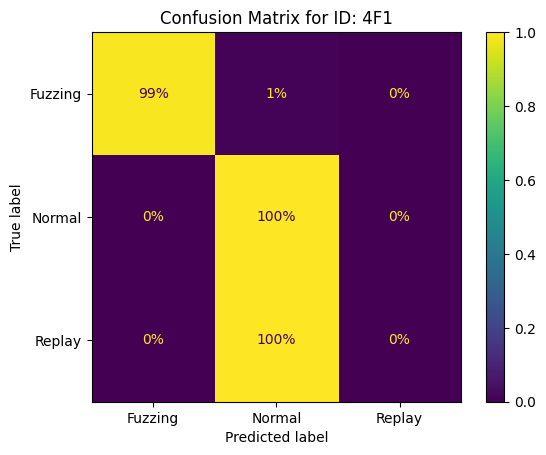

<Figure size 800x600 with 0 Axes>





Processing ID: 130
Epoch 1/100
362/362 [==============================] - 3s 6ms/step - loss: 0.1890 - accuracy: 0.9743 - val_loss: 0.1040 - val_accuracy: 0.9808
Epoch 2/100
362/362 [==============================] - 3s 8ms/step - loss: 0.1085 - accuracy: 0.9860 - val_loss: 0.0949 - val_accuracy: 0.9811
Epoch 3/100
362/362 [==============================] - 3s 10ms/step - loss: 0.1010 - accuracy: 0.9863 - val_loss: 0.0952 - val_accuracy: 0.9809
Epoch 4/100
362/362 [==============================] - 2s 6ms/step - loss: 0.0938 - accuracy: 0.9864 - val_loss: 0.0929 - val_accuracy: 0.9814
Epoch 5/100
362/362 [==============================] - 2s 6ms/step - loss: 0.1028 - accuracy: 0.9864 - val_loss: 0.0932 - val_accuracy: 0.9815
Epoch 6/100
362/362 [==============================] - 2s 6ms/step - loss: 0.1010 - accuracy: 0.9864 - val_loss: 0.0940 - val_accuracy: 0.9815
Epoch 7/100
362/362 [==============================] - 2s 6ms/step - loss: 0.1029 - accuracy: 0.9864 - val_loss: 0.093

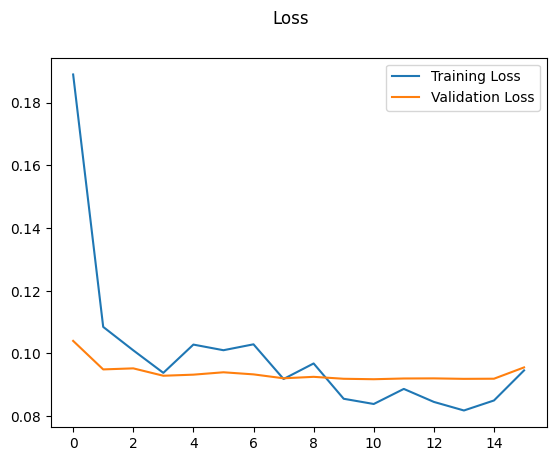

Result:

     Accuracy  F1 Score  Precision    Recall
130  0.979575  0.662694    0.99278  0.666014

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00      1028
      Normal       0.98      1.00      0.99     74657
      Replay       0.00      0.00      0.00      1575

    accuracy                           0.98     77260
   macro avg       0.66      0.67      0.66     77260
weighted avg       0.96      0.98      0.97     77260



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


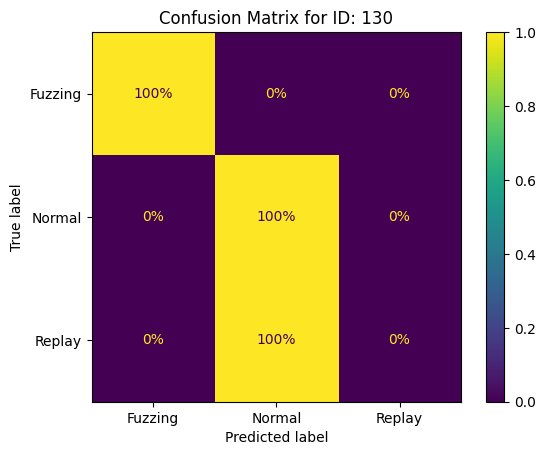

<Figure size 800x600 with 0 Axes>





Processing ID: 140
Epoch 1/100
362/362 [==============================] - 4s 8ms/step - loss: 0.1929 - accuracy: 0.9723 - val_loss: 0.1021 - val_accuracy: 0.9812
Epoch 2/100
362/362 [==============================] - 3s 9ms/step - loss: 0.1122 - accuracy: 0.9860 - val_loss: 0.0962 - val_accuracy: 0.9814
Epoch 3/100
362/362 [==============================] - 2s 6ms/step - loss: 0.1020 - accuracy: 0.9864 - val_loss: 0.0923 - val_accuracy: 0.9816
Epoch 4/100
362/362 [==============================] - 2s 6ms/step - loss: 0.0987 - accuracy: 0.9864 - val_loss: 0.0931 - val_accuracy: 0.9816
Epoch 5/100
362/362 [==============================] - 2s 6ms/step - loss: 0.0909 - accuracy: 0.9865 - val_loss: 0.0925 - val_accuracy: 0.9816
Epoch 6/100
362/362 [==============================] - 2s 6ms/step - loss: 0.0913 - accuracy: 0.9865 - val_loss: 0.0925 - val_accuracy: 0.9816
Epoch 7/100
362/362 [==============================] - 2s 6ms/step - loss: 0.0872 - accuracy: 0.9865 - val_loss: 0.0926

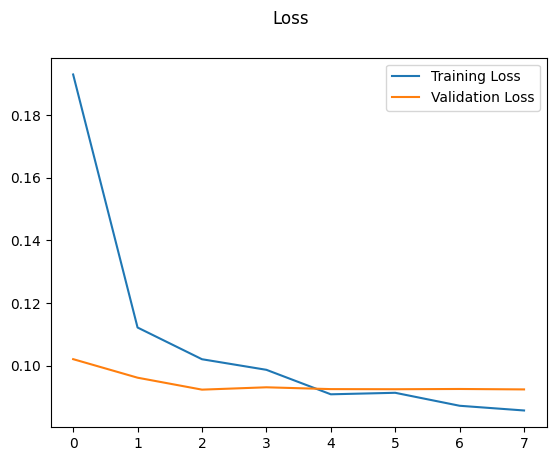

Result:

     Accuracy  F1 Score  Precision    Recall
140  0.979463  0.661327   0.993065  0.663015

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.99      0.99      1004
      Normal       0.98      1.00      0.99     74648
      Replay       0.00      0.00      0.00      1575

    accuracy                           0.98     77227
   macro avg       0.66      0.66      0.66     77227
weighted avg       0.96      0.98      0.97     77227



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


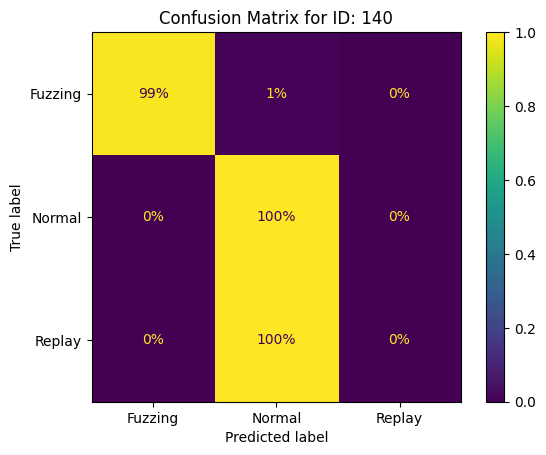

<Figure size 800x600 with 0 Axes>





Processing ID: 356
Epoch 1/100
360/360 [==============================] - 3s 6ms/step - loss: 0.2189 - accuracy: 0.9768 - val_loss: 0.1401 - val_accuracy: 0.9733
Epoch 2/100
360/360 [==============================] - 2s 6ms/step - loss: 0.1559 - accuracy: 0.9792 - val_loss: 0.1358 - val_accuracy: 0.9733
Epoch 3/100
360/360 [==============================] - 3s 8ms/step - loss: 0.1459 - accuracy: 0.9792 - val_loss: 0.1342 - val_accuracy: 0.9733
Epoch 4/100
360/360 [==============================] - 3s 9ms/step - loss: 0.1344 - accuracy: 0.9792 - val_loss: 0.1306 - val_accuracy: 0.9733
Epoch 5/100
360/360 [==============================] - 2s 6ms/step - loss: 0.1286 - accuracy: 0.9792 - val_loss: 0.1290 - val_accuracy: 0.9733
Epoch 6/100
360/360 [==============================] - 2s 6ms/step - loss: 0.1227 - accuracy: 0.9792 - val_loss: 0.1274 - val_accuracy: 0.9733
Epoch 7/100
360/360 [==============================] - 2s 6ms/step - loss: 0.1217 - accuracy: 0.9792 - val_loss: 0.1266

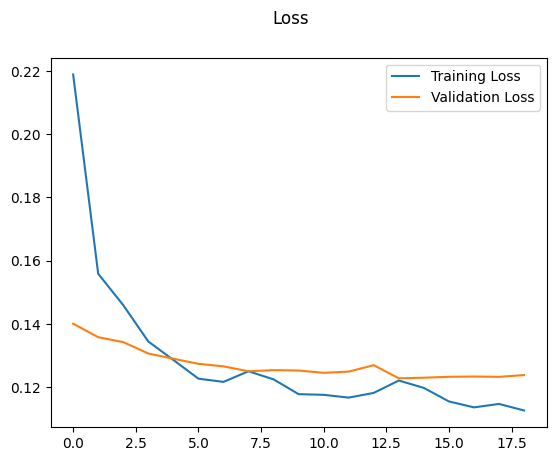

Result:

     Accuracy  F1 Score  Precision    Recall
356  0.972648  0.328712   0.990883  0.333333

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       0.00      0.00      0.00       526
      Normal       0.97      1.00      0.99     74749
      Replay       0.00      0.00      0.00      1576

    accuracy                           0.97     76851
   macro avg       0.32      0.33      0.33     76851
weighted avg       0.95      0.97      0.96     76851



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


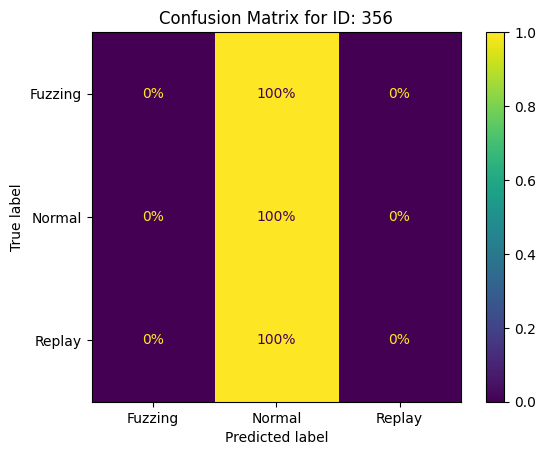

<Figure size 800x600 with 0 Axes>





Processing ID: 153
Epoch 1/100
362/362 [==============================] - 4s 9ms/step - loss: 0.1546 - accuracy: 0.9671 - val_loss: 0.1086 - val_accuracy: 0.9816
Epoch 2/100
362/362 [==============================] - 3s 9ms/step - loss: 0.0894 - accuracy: 0.9865 - val_loss: 0.0997 - val_accuracy: 0.9815
Epoch 3/100
362/362 [==============================] - 2s 6ms/step - loss: 0.0791 - accuracy: 0.9865 - val_loss: 0.0965 - val_accuracy: 0.9816
Epoch 4/100
362/362 [==============================] - 2s 6ms/step - loss: 0.0730 - accuracy: 0.9865 - val_loss: 0.0884 - val_accuracy: 0.9816
Epoch 5/100
362/362 [==============================] - 2s 6ms/step - loss: 0.0724 - accuracy: 0.9865 - val_loss: 0.0936 - val_accuracy: 0.9816
Epoch 6/100
362/362 [==============================] - 2s 6ms/step - loss: 0.0736 - accuracy: 0.9865 - val_loss: 0.0891 - val_accuracy: 0.9816
Epoch 7/100
362/362 [==============================] - 3s 7ms/step - loss: 0.0731 - accuracy: 0.9865 - val_loss: 0.0845

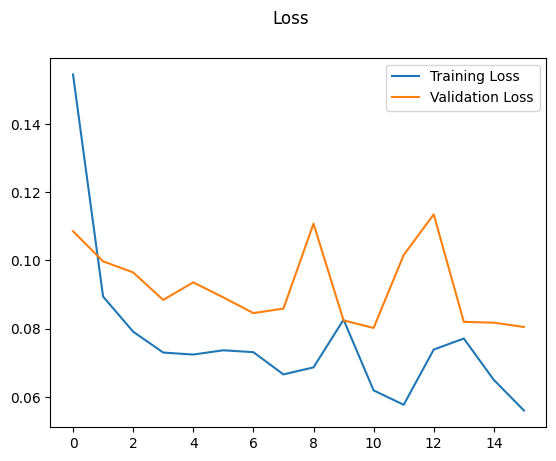

Result:

     Accuracy  F1 Score  Precision    Recall
153  0.979563   0.66284     0.9931  0.665986

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       980
      Normal       0.98      1.00      0.99     74658
      Replay       0.00      0.00      0.00      1576

    accuracy                           0.98     77214
   macro avg       0.66      0.67      0.66     77214
weighted avg       0.96      0.98      0.97     77214



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


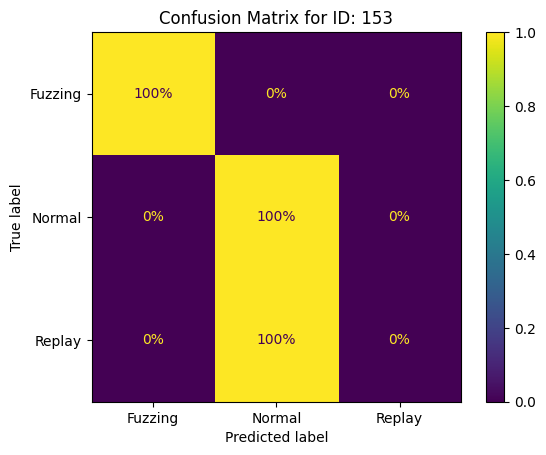

<Figure size 800x600 with 0 Axes>





Processing ID: 220
Epoch 1/100
363/363 [==============================] - 4s 8ms/step - loss: 0.1588 - accuracy: 0.9635 - val_loss: 0.1092 - val_accuracy: 0.9794
Epoch 2/100
363/363 [==============================] - 2s 6ms/step - loss: 0.0788 - accuracy: 0.9841 - val_loss: 0.1073 - val_accuracy: 0.9799
Epoch 3/100
363/363 [==============================] - 2s 6ms/step - loss: 0.0726 - accuracy: 0.9852 - val_loss: 0.0978 - val_accuracy: 0.9797
Epoch 4/100
363/363 [==============================] - 2s 6ms/step - loss: 0.0624 - accuracy: 0.9860 - val_loss: 0.1023 - val_accuracy: 0.9805
Epoch 5/100
363/363 [==============================] - 2s 6ms/step - loss: 0.0549 - accuracy: 0.9861 - val_loss: 0.1061 - val_accuracy: 0.9810
Epoch 6/100
363/363 [==============================] - 4s 10ms/step - loss: 0.0438 - accuracy: 0.9862 - val_loss: 0.1201 - val_accuracy: 0.9808
Epoch 7/100
363/363 [==============================] - 4s 10ms/step - loss: 0.0950 - accuracy: 0.9859 - val_loss: 0.13

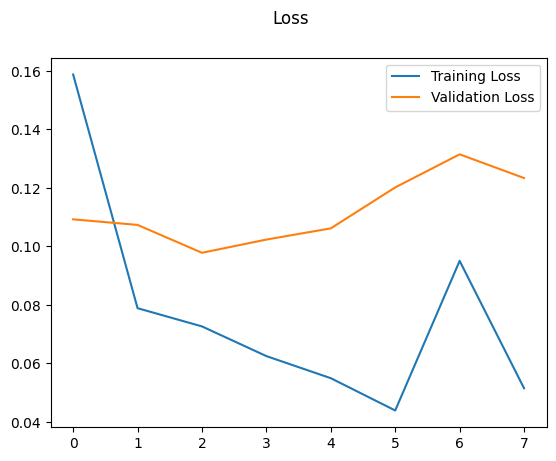

Result:

     Accuracy  F1 Score  Precision    Recall
220  0.978805  0.652869   0.987823  0.651478

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       0.98      0.95      0.97      1014
      Normal       0.98      1.00      0.99     74647
      Replay       0.00      0.00      0.00      1576

    accuracy                           0.98     77237
   macro avg       0.65      0.65      0.65     77237
weighted avg       0.96      0.98      0.97     77237



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


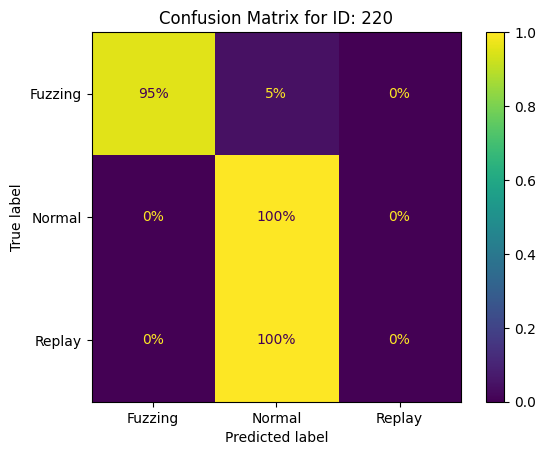

<Figure size 800x600 with 0 Axes>





Processing ID: 367
Epoch 1/100
359/359 [==============================] - 4s 7ms/step - loss: 0.1621 - accuracy: 0.9777 - val_loss: 0.1104 - val_accuracy: 0.9800
Epoch 2/100
359/359 [==============================] - 2s 6ms/step - loss: 0.1231 - accuracy: 0.9853 - val_loss: 0.0993 - val_accuracy: 0.9800
Epoch 3/100
359/359 [==============================] - 2s 6ms/step - loss: 0.1162 - accuracy: 0.9856 - val_loss: 0.0992 - val_accuracy: 0.9803
Epoch 4/100
359/359 [==============================] - 3s 9ms/step - loss: 0.1049 - accuracy: 0.9845 - val_loss: 0.1043 - val_accuracy: 0.9800
Epoch 5/100
359/359 [==============================] - 4s 11ms/step - loss: 0.1000 - accuracy: 0.9855 - val_loss: 0.1006 - val_accuracy: 0.9796
Epoch 6/100
359/359 [==============================] - 2s 7ms/step - loss: 0.0977 - accuracy: 0.9848 - val_loss: 0.1050 - val_accuracy: 0.9798
Epoch 7/100
359/359 [==============================] - 2s 6ms/step - loss: 0.0959 - accuracy: 0.9855 - val_loss: 0.101

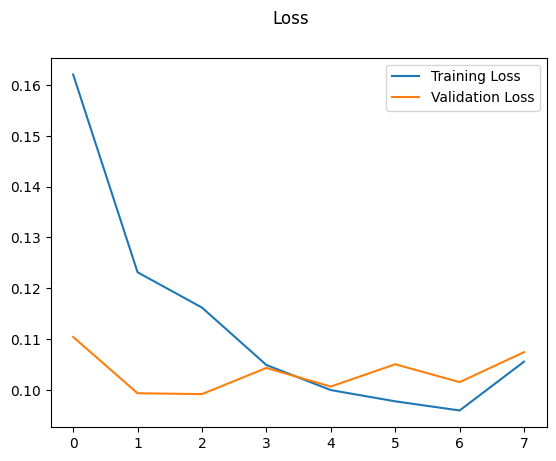

Result:

     Accuracy  F1 Score  Precision    Recall
367  0.606479  0.261654   0.660772  0.517176

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       0.02      0.93      0.03       503
      Normal       0.97      0.62      0.75     74684
      Replay       0.00      0.00      0.00      1584

    accuracy                           0.61     76771
   macro avg       0.33      0.52      0.26     76771
weighted avg       0.94      0.61      0.73     76771



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


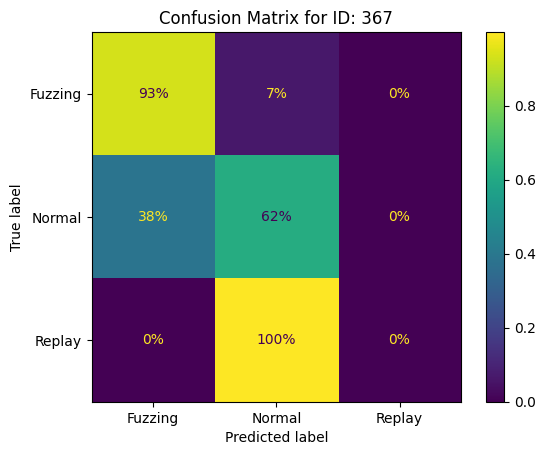

<Figure size 800x600 with 0 Axes>





Processing ID: 368
Epoch 1/100
359/359 [==============================] - 6s 12ms/step - loss: 0.1472 - accuracy: 0.9791 - val_loss: 0.0829 - val_accuracy: 0.9813
Epoch 2/100
359/359 [==============================] - 2s 7ms/step - loss: 0.0554 - accuracy: 0.9862 - val_loss: 0.1038 - val_accuracy: 0.9815
Epoch 3/100
359/359 [==============================] - 3s 7ms/step - loss: 0.0515 - accuracy: 0.9862 - val_loss: 0.1078 - val_accuracy: 0.9815
Epoch 4/100
359/359 [==============================] - 3s 7ms/step - loss: 0.0488 - accuracy: 0.9863 - val_loss: 0.1148 - val_accuracy: 0.9815
Epoch 5/100
359/359 [==============================] - 3s 10ms/step - loss: 0.0510 - accuracy: 0.9862 - val_loss: 0.0967 - val_accuracy: 0.9815
Epoch 6/100
2397/2397 [==============================] - 5s 2ms/step


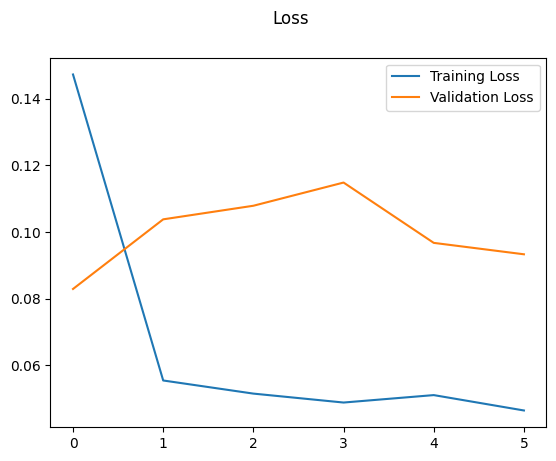

Result:

     Accuracy  F1 Score  Precision    Recall
368  0.979166  0.655453   0.993015  0.651645

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.95      0.98       466
      Normal       0.98      1.00      0.99     74657
      Replay       0.00      0.00      0.00      1577

    accuracy                           0.98     76700
   macro avg       0.66      0.65      0.66     76700
weighted avg       0.96      0.98      0.97     76700



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


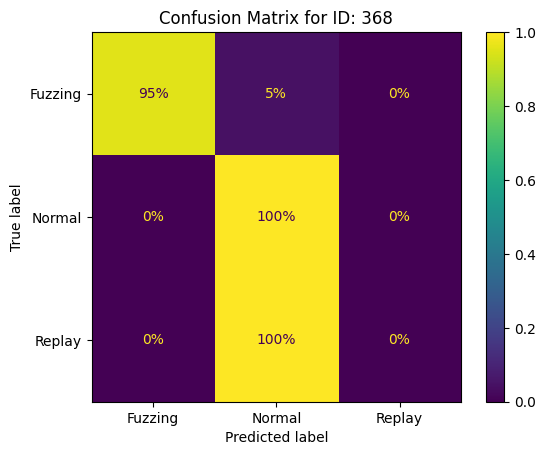

<Figure size 800x600 with 0 Axes>





Processing ID: 412
Epoch 1/100
21/21 [==============================] - 2s 19ms/step - loss: 0.6678 - accuracy: 0.8324 - val_loss: 0.3305 - val_accuracy: 0.8381
Epoch 2/100
21/21 [==============================] - 0s 9ms/step - loss: 0.1925 - accuracy: 0.9385 - val_loss: 0.1240 - val_accuracy: 0.9840
Epoch 3/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0914 - accuracy: 0.9870 - val_loss: 0.0951 - val_accuracy: 0.9840
Epoch 4/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0766 - accuracy: 0.9874 - val_loss: 0.0852 - val_accuracy: 0.9840
Epoch 5/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0705 - accuracy: 0.9878 - val_loss: 0.0829 - val_accuracy: 0.9840
Epoch 6/100
21/21 [==============================] - 0s 12ms/step - loss: 0.0724 - accuracy: 0.9878 - val_loss: 0.0815 - val_accuracy: 0.9840
Epoch 7/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0674 - accuracy: 0.9878 - val_loss: 0.0815 - val_accu

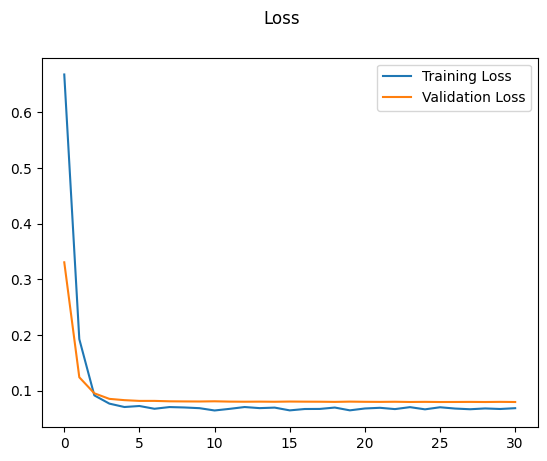

Result:

     Accuracy  F1 Score  Precision    Recall
412  0.981713  0.663174   0.993087  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       511
      Normal       0.98      1.00      0.99      3730
      Replay       0.00      0.00      0.00        79

    accuracy                           0.98      4320
   macro avg       0.66      0.67      0.66      4320
weighted avg       0.96      0.98      0.97      4320



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


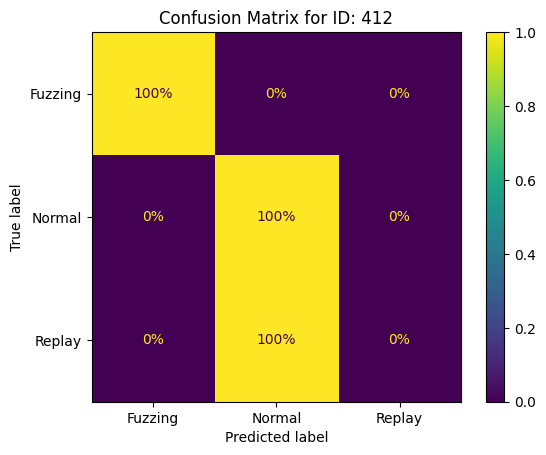

<Figure size 800x600 with 0 Axes>





Processing ID: 470
Epoch 1/100
181/181 [==============================] - 3s 11ms/step - loss: 0.2873 - accuracy: 0.9670 - val_loss: 0.1847 - val_accuracy: 0.9660
Epoch 2/100
181/181 [==============================] - 2s 10ms/step - loss: 0.1486 - accuracy: 0.9762 - val_loss: 0.1304 - val_accuracy: 0.9782
Epoch 3/100
181/181 [==============================] - 2s 10ms/step - loss: 0.1192 - accuracy: 0.9836 - val_loss: 0.1127 - val_accuracy: 0.9798
Epoch 4/100
181/181 [==============================] - 2s 9ms/step - loss: 0.1055 - accuracy: 0.9851 - val_loss: 0.1053 - val_accuracy: 0.9804
Epoch 5/100
181/181 [==============================] - 1s 8ms/step - loss: 0.1034 - accuracy: 0.9853 - val_loss: 0.1040 - val_accuracy: 0.9810
Epoch 6/100
181/181 [==============================] - 1s 6ms/step - loss: 0.0966 - accuracy: 0.9858 - val_loss: 0.0998 - val_accuracy: 0.9811
Epoch 7/100
181/181 [==============================] - 1s 6ms/step - loss: 0.0924 - accuracy: 0.9860 - val_loss: 0.0

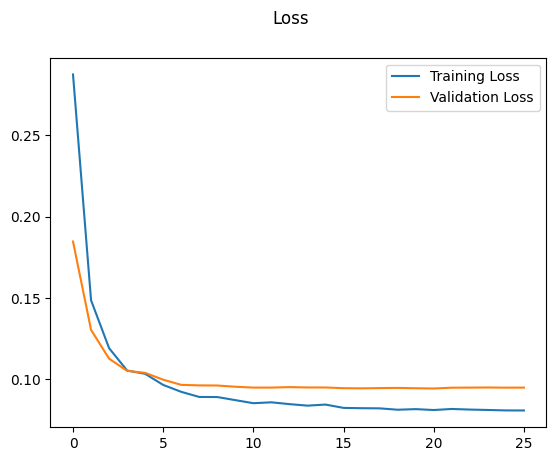

Result:

     Accuracy  F1 Score  Precision    Recall
470  0.979182  0.658485    0.99297  0.657534

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.97      0.99       511
      Normal       0.98      1.00      0.99     37225
      Replay       0.00      0.00      0.00       788

    accuracy                           0.98     38524
   macro avg       0.66      0.66      0.66     38524
weighted avg       0.96      0.98      0.97     38524



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


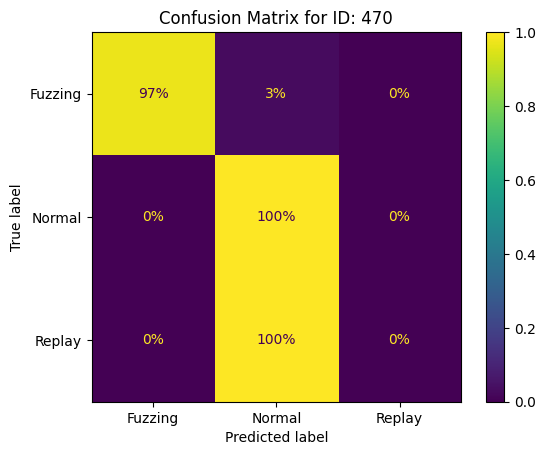

<Figure size 800x600 with 0 Axes>





Processing ID: 38D
Epoch 1/100
181/181 [==============================] - 4s 13ms/step - loss: 0.2287 - accuracy: 0.9696 - val_loss: 0.1271 - val_accuracy: 0.9778
Epoch 2/100
181/181 [==============================] - 2s 11ms/step - loss: 0.1151 - accuracy: 0.9858 - val_loss: 0.1027 - val_accuracy: 0.9811
Epoch 3/100
181/181 [==============================] - 1s 6ms/step - loss: 0.0976 - accuracy: 0.9863 - val_loss: 0.0997 - val_accuracy: 0.9814
Epoch 4/100
181/181 [==============================] - 1s 6ms/step - loss: 0.0954 - accuracy: 0.9863 - val_loss: 0.1012 - val_accuracy: 0.9817
Epoch 5/100
181/181 [==============================] - 1s 7ms/step - loss: 0.0926 - accuracy: 0.9863 - val_loss: 0.0994 - val_accuracy: 0.9817
Epoch 6/100
181/181 [==============================] - 1s 6ms/step - loss: 0.0944 - accuracy: 0.9863 - val_loss: 0.0989 - val_accuracy: 0.9817
Epoch 7/100
181/181 [==============================] - 1s 6ms/step - loss: 0.0819 - accuracy: 0.9864 - val_loss: 0.09

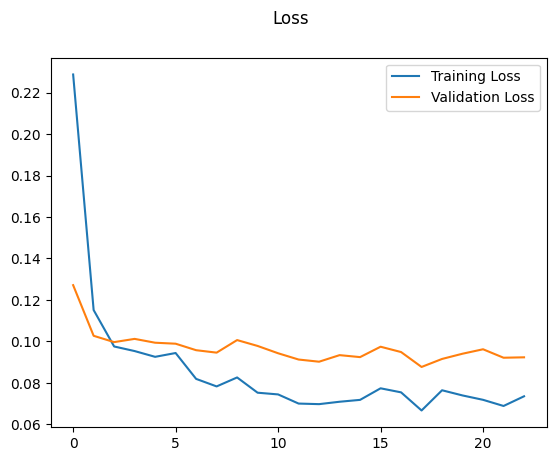

Result:

     Accuracy  F1 Score  Precision    Recall
38D  0.979569  0.662848     0.9931  0.666001

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       501
      Normal       0.98      1.00      0.99     37328
      Replay       0.00      0.00      0.00       788

    accuracy                           0.98     38617
   macro avg       0.66      0.67      0.66     38617
weighted avg       0.96      0.98      0.97     38617



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


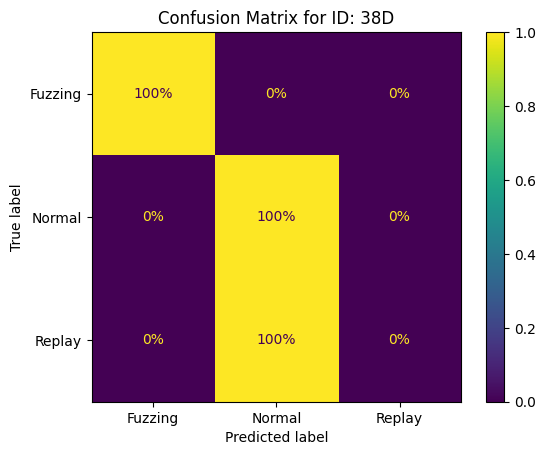

<Figure size 800x600 with 0 Axes>





Processing ID: 420
Epoch 1/100
181/181 [==============================] - 2s 7ms/step - loss: 0.2329 - accuracy: 0.9647 - val_loss: 0.1322 - val_accuracy: 0.9655
Epoch 2/100
181/181 [==============================] - 1s 7ms/step - loss: 0.1089 - accuracy: 0.9820 - val_loss: 0.0995 - val_accuracy: 0.9813
Epoch 3/100
181/181 [==============================] - 1s 7ms/step - loss: 0.1028 - accuracy: 0.9863 - val_loss: 0.1111 - val_accuracy: 0.9809
Epoch 4/100
181/181 [==============================] - 1s 6ms/step - loss: 0.0935 - accuracy: 0.9860 - val_loss: 0.1165 - val_accuracy: 0.9817
Epoch 5/100
181/181 [==============================] - 1s 6ms/step - loss: 0.0891 - accuracy: 0.9864 - val_loss: 0.1043 - val_accuracy: 0.9814
Epoch 6/100
181/181 [==============================] - 2s 9ms/step - loss: 0.0815 - accuracy: 0.9864 - val_loss: 0.1036 - val_accuracy: 0.9814
Epoch 7/100
181/181 [==============================] - 2s 9ms/step - loss: 0.0735 - accuracy: 0.9864 - val_loss: 0.0908

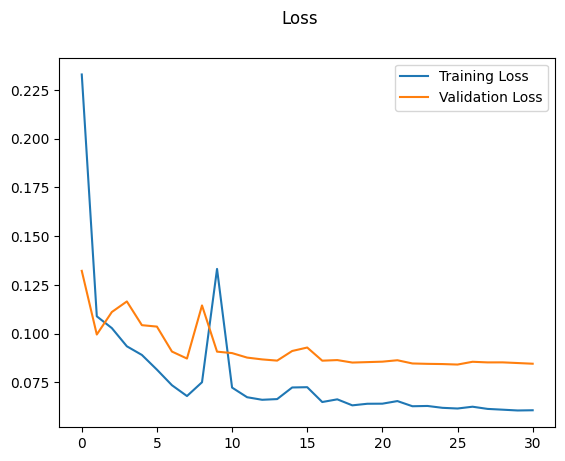

Result:

     Accuracy  F1 Score  Precision    Recall
420  0.979554  0.662845   0.993095  0.666001

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       501
      Normal       0.98      1.00      0.99     37301
      Replay       0.00      0.00      0.00       788

    accuracy                           0.98     38590
   macro avg       0.66      0.67      0.66     38590
weighted avg       0.96      0.98      0.97     38590



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


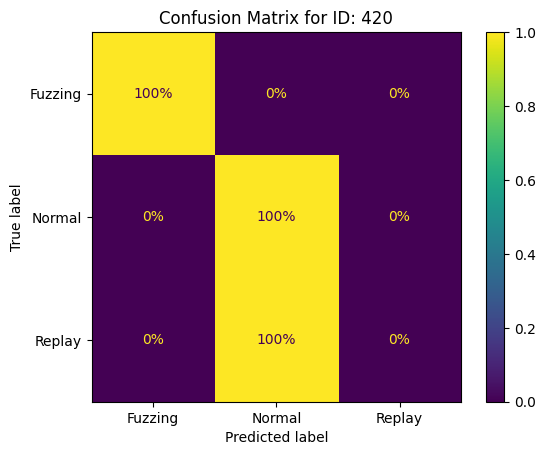

<Figure size 800x600 with 0 Axes>





Processing ID: 421
Epoch 1/100
181/181 [==============================] - 2s 7ms/step - loss: 0.2096 - accuracy: 0.9666 - val_loss: 0.1280 - val_accuracy: 0.9793
Epoch 2/100
181/181 [==============================] - 1s 7ms/step - loss: 0.1180 - accuracy: 0.9855 - val_loss: 0.1114 - val_accuracy: 0.9814
Epoch 3/100
181/181 [==============================] - 1s 6ms/step - loss: 0.1064 - accuracy: 0.9861 - val_loss: 0.1066 - val_accuracy: 0.9816
Epoch 4/100
181/181 [==============================] - 1s 7ms/step - loss: 0.1046 - accuracy: 0.9862 - val_loss: 0.1072 - val_accuracy: 0.9815
Epoch 5/100
181/181 [==============================] - 2s 9ms/step - loss: 0.0918 - accuracy: 0.9862 - val_loss: 0.1018 - val_accuracy: 0.9816
Epoch 6/100
181/181 [==============================] - 2s 9ms/step - loss: 0.1005 - accuracy: 0.9863 - val_loss: 0.1072 - val_accuracy: 0.9815
Epoch 7/100
181/181 [==============================] - 2s 9ms/step - loss: 0.0959 - accuracy: 0.9863 - val_loss: 0.1099

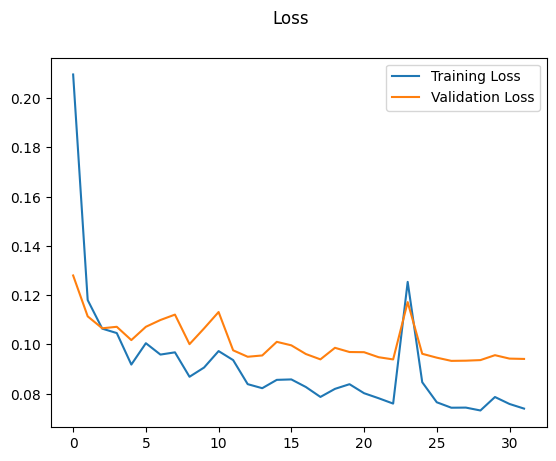

Result:

     Accuracy  F1 Score  Precision    Recall
421  0.979543  0.662842   0.993092  0.665999

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       499
      Normal       0.98      1.00      0.99     37282
      Replay       0.00      0.00      0.00       788

    accuracy                           0.98     38569
   macro avg       0.66      0.67      0.66     38569
weighted avg       0.96      0.98      0.97     38569



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


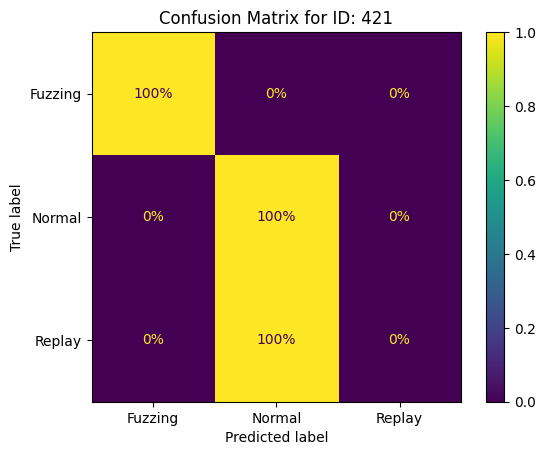

<Figure size 800x600 with 0 Axes>





Processing ID: 389
Epoch 1/100
181/181 [==============================] - 2s 8ms/step - loss: 0.2326 - accuracy: 0.9627 - val_loss: 0.1385 - val_accuracy: 0.9721
Epoch 2/100
181/181 [==============================] - 1s 6ms/step - loss: 0.1178 - accuracy: 0.9855 - val_loss: 0.1017 - val_accuracy: 0.9812
Epoch 3/100
181/181 [==============================] - 1s 7ms/step - loss: 0.1083 - accuracy: 0.9863 - val_loss: 0.1008 - val_accuracy: 0.9816
Epoch 4/100
181/181 [==============================] - 1s 7ms/step - loss: 0.1069 - accuracy: 0.9864 - val_loss: 0.1041 - val_accuracy: 0.9816
Epoch 5/100
181/181 [==============================] - 1s 6ms/step - loss: 0.1038 - accuracy: 0.9864 - val_loss: 0.0972 - val_accuracy: 0.9816
Epoch 6/100
181/181 [==============================] - 1s 8ms/step - loss: 0.0983 - accuracy: 0.9864 - val_loss: 0.0975 - val_accuracy: 0.9816
Epoch 7/100
181/181 [==============================] - 2s 9ms/step - loss: 0.1003 - accuracy: 0.9864 - val_loss: 0.0959

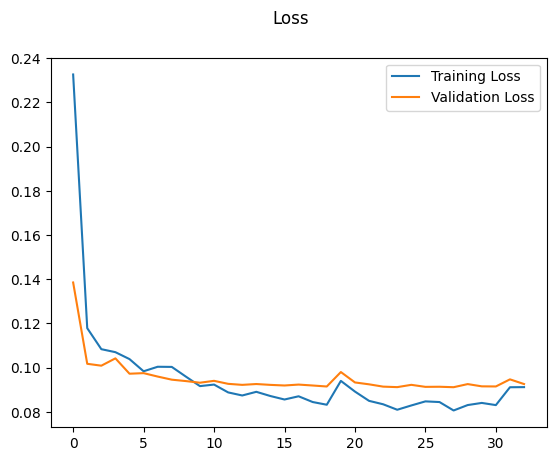

Result:

     Accuracy  F1 Score  Precision    Recall
389  0.979586  0.663184   0.993107  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       493
      Normal       0.98      1.00      0.99     37272
      Replay       0.00      0.00      0.00       787

    accuracy                           0.98     38552
   macro avg       0.66      0.67      0.66     38552
weighted avg       0.96      0.98      0.97     38552



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


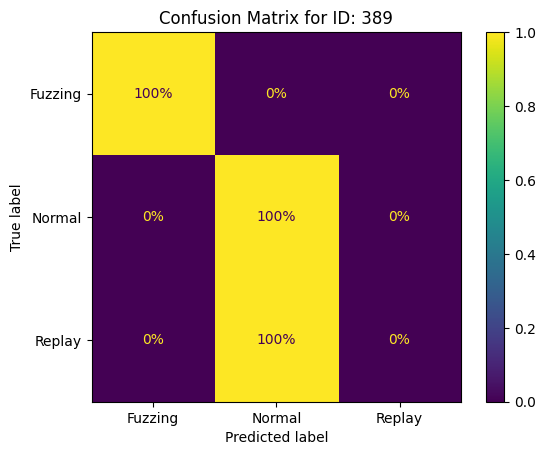

<Figure size 800x600 with 0 Axes>





Processing ID: 386
Epoch 1/100
181/181 [==============================] - 2s 8ms/step - loss: 0.2987 - accuracy: 0.9579 - val_loss: 0.1705 - val_accuracy: 0.9662
Epoch 2/100
181/181 [==============================] - 1s 7ms/step - loss: 0.1386 - accuracy: 0.9766 - val_loss: 0.1128 - val_accuracy: 0.9817
Epoch 3/100
181/181 [==============================] - 1s 7ms/step - loss: 0.1040 - accuracy: 0.9861 - val_loss: 0.1008 - val_accuracy: 0.9817
Epoch 4/100
181/181 [==============================] - 1s 7ms/step - loss: 0.0941 - accuracy: 0.9862 - val_loss: 0.0969 - val_accuracy: 0.9817
Epoch 5/100
181/181 [==============================] - 1s 7ms/step - loss: 0.0863 - accuracy: 0.9864 - val_loss: 0.0931 - val_accuracy: 0.9817
Epoch 6/100
181/181 [==============================] - 1s 7ms/step - loss: 0.0924 - accuracy: 0.9864 - val_loss: 0.0952 - val_accuracy: 0.9817
Epoch 7/100
181/181 [==============================] - 2s 10ms/step - loss: 0.0828 - accuracy: 0.9863 - val_loss: 0.092

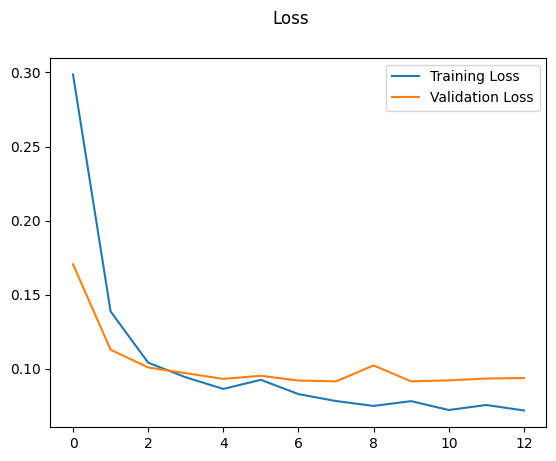

Result:

     Accuracy  F1 Score  Precision    Recall
386  0.979563  0.662849   0.993098  0.666007

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       505
      Normal       0.98      1.00      0.99     37314
      Replay       0.00      0.00      0.00       788

    accuracy                           0.98     38607
   macro avg       0.66      0.67      0.66     38607
weighted avg       0.96      0.98      0.97     38607



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


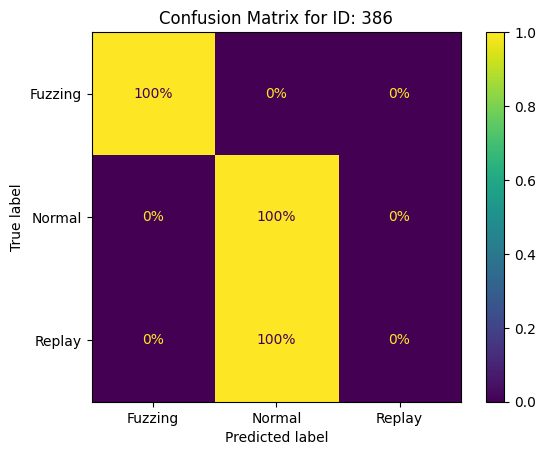

<Figure size 800x600 with 0 Axes>





Processing ID: 492
Epoch 1/100
74/74 [==============================] - 3s 15ms/step - loss: 0.3319 - accuracy: 0.9384 - val_loss: 0.1632 - val_accuracy: 0.9426
Epoch 2/100
74/74 [==============================] - 1s 11ms/step - loss: 0.1098 - accuracy: 0.9806 - val_loss: 0.0956 - val_accuracy: 0.9820
Epoch 3/100
74/74 [==============================] - 1s 11ms/step - loss: 0.0861 - accuracy: 0.9866 - val_loss: 0.0909 - val_accuracy: 0.9820
Epoch 4/100
74/74 [==============================] - 1s 11ms/step - loss: 0.0835 - accuracy: 0.9867 - val_loss: 0.0901 - val_accuracy: 0.9820
Epoch 5/100
74/74 [==============================] - 1s 8ms/step - loss: 0.0832 - accuracy: 0.9866 - val_loss: 0.0898 - val_accuracy: 0.9820
Epoch 6/100
74/74 [==============================] - 1s 8ms/step - loss: 0.0814 - accuracy: 0.9867 - val_loss: 0.0897 - val_accuracy: 0.9820
Epoch 7/100
74/74 [==============================] - 1s 7ms/step - loss: 0.0823 - accuracy: 0.9867 - val_loss: 0.0896 - val_acc

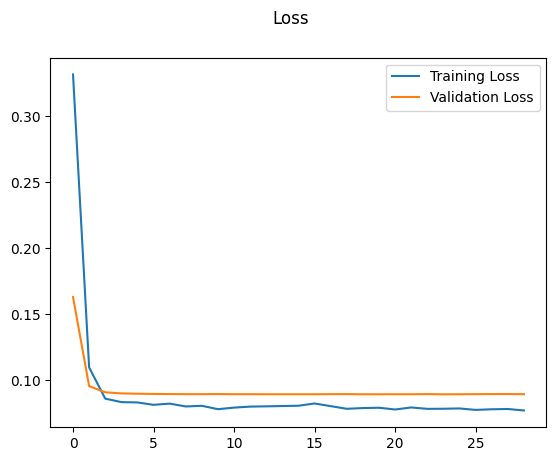

Result:

     Accuracy  F1 Score  Precision    Recall
492  0.979918  0.663187   0.993112  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       442
      Normal       0.98      1.00      0.99     14929
      Replay       0.00      0.00      0.00       315

    accuracy                           0.98     15686
   macro avg       0.66      0.67      0.66     15686
weighted avg       0.96      0.98      0.97     15686



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


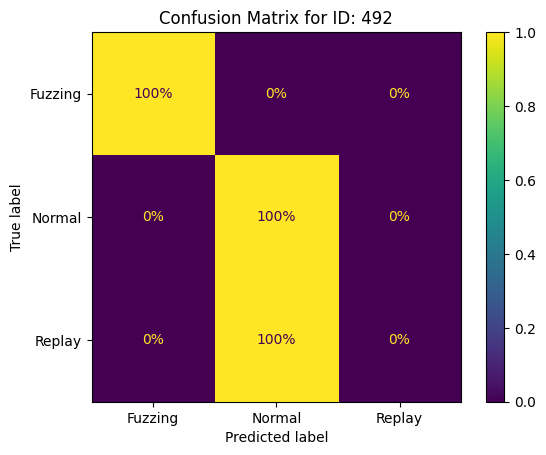

<Figure size 800x600 with 0 Axes>





Processing ID: 391
Epoch 1/100
181/181 [==============================] - 2s 8ms/step - loss: 0.5450 - accuracy: 0.9732 - val_loss: 0.1081 - val_accuracy: 0.9794
Epoch 2/100
181/181 [==============================] - 1s 7ms/step - loss: 0.1007 - accuracy: 0.9854 - val_loss: 0.1008 - val_accuracy: 0.9807
Epoch 3/100
181/181 [==============================] - 1s 7ms/step - loss: 0.1004 - accuracy: 0.9857 - val_loss: 0.1001 - val_accuracy: 0.9807
Epoch 4/100
181/181 [==============================] - 1s 7ms/step - loss: 0.0972 - accuracy: 0.9857 - val_loss: 0.0994 - val_accuracy: 0.9807
Epoch 5/100
181/181 [==============================] - 1s 8ms/step - loss: 0.0951 - accuracy: 0.9857 - val_loss: 0.0996 - val_accuracy: 0.9807
Epoch 6/100
181/181 [==============================] - 2s 9ms/step - loss: 0.0944 - accuracy: 0.9857 - val_loss: 0.0989 - val_accuracy: 0.9807
Epoch 7/100
181/181 [==============================] - 2s 10ms/step - loss: 0.0921 - accuracy: 0.9857 - val_loss: 0.098

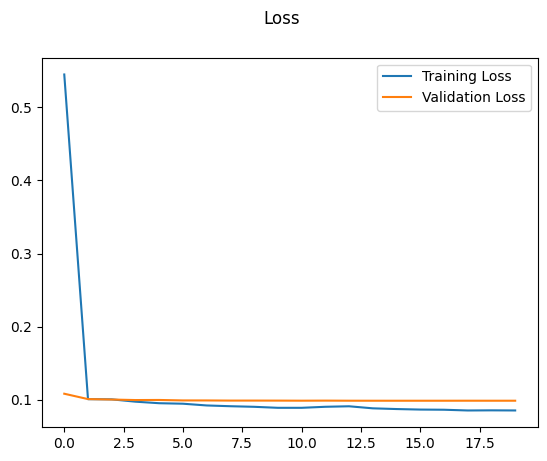

Result:

     Accuracy  F1 Score  Precision    Recall
391  0.978676  0.650908   0.992803  0.643275

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.93      0.96       513
      Normal       0.98      1.00      0.99     37341
      Replay       0.00      0.00      0.00       788

    accuracy                           0.98     38642
   macro avg       0.66      0.64      0.65     38642
weighted avg       0.96      0.98      0.97     38642



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


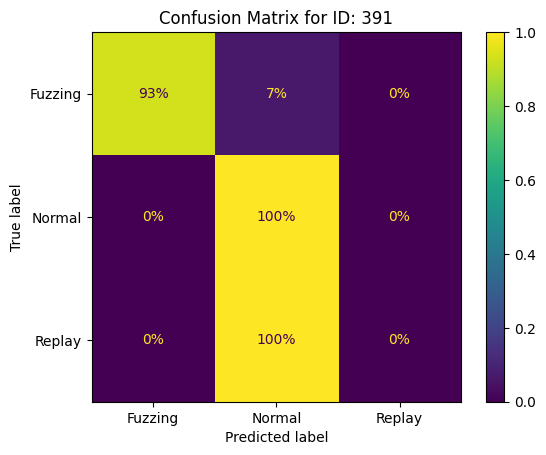

<Figure size 800x600 with 0 Axes>





Processing ID: 485
Epoch 1/100
75/75 [==============================] - 2s 10ms/step - loss: 0.2849 - accuracy: 0.9350 - val_loss: 0.1527 - val_accuracy: 0.9434
Epoch 2/100
75/75 [==============================] - 1s 7ms/step - loss: 0.1192 - accuracy: 0.9749 - val_loss: 0.0950 - val_accuracy: 0.9820
Epoch 3/100
75/75 [==============================] - 1s 8ms/step - loss: 0.0828 - accuracy: 0.9867 - val_loss: 0.0899 - val_accuracy: 0.9820
Epoch 4/100
75/75 [==============================] - 1s 7ms/step - loss: 0.0843 - accuracy: 0.9867 - val_loss: 0.0885 - val_accuracy: 0.9820
Epoch 5/100
75/75 [==============================] - 1s 8ms/step - loss: 0.0817 - accuracy: 0.9867 - val_loss: 0.0878 - val_accuracy: 0.9820
Epoch 6/100
75/75 [==============================] - 1s 7ms/step - loss: 0.0787 - accuracy: 0.9867 - val_loss: 0.0876 - val_accuracy: 0.9820
Epoch 7/100
75/75 [==============================] - 1s 8ms/step - loss: 0.0785 - accuracy: 0.9867 - val_loss: 0.0871 - val_accura

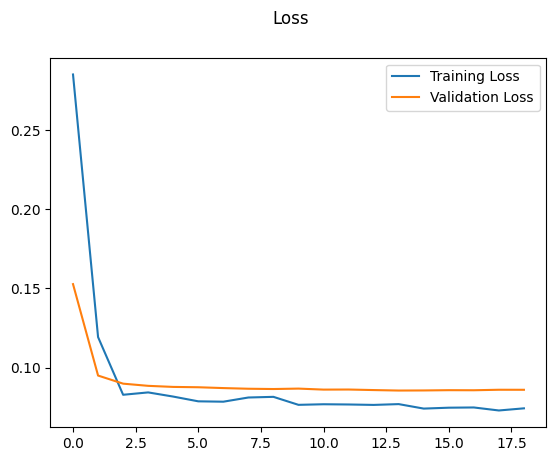

Result:

     Accuracy  F1 Score  Precision    Recall
485   0.97993  0.663182   0.993102  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       473
      Normal       0.98      1.00      0.99     14907
      Replay       0.00      0.00      0.00       315

    accuracy                           0.98     15695
   macro avg       0.66      0.67      0.66     15695
weighted avg       0.96      0.98      0.97     15695



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


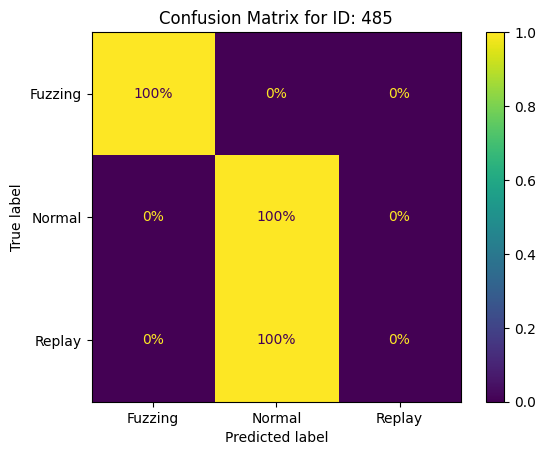

<Figure size 800x600 with 0 Axes>





Processing ID: 490
Epoch 1/100
75/75 [==============================] - 2s 14ms/step - loss: 0.3583 - accuracy: 0.9357 - val_loss: 0.1533 - val_accuracy: 0.9511
Epoch 2/100
75/75 [==============================] - 1s 9ms/step - loss: 0.1026 - accuracy: 0.9816 - val_loss: 0.0928 - val_accuracy: 0.9821
Epoch 3/100
75/75 [==============================] - 1s 11ms/step - loss: 0.0782 - accuracy: 0.9869 - val_loss: 0.0904 - val_accuracy: 0.9821
Epoch 4/100
75/75 [==============================] - 1s 11ms/step - loss: 0.0755 - accuracy: 0.9869 - val_loss: 0.0913 - val_accuracy: 0.9821
Epoch 5/100
75/75 [==============================] - 1s 10ms/step - loss: 0.0757 - accuracy: 0.9870 - val_loss: 0.0907 - val_accuracy: 0.9821
Epoch 6/100
75/75 [==============================] - 1s 10ms/step - loss: 0.0728 - accuracy: 0.9877 - val_loss: 0.0910 - val_accuracy: 0.9821
Epoch 7/100
75/75 [==============================] - 1s 10ms/step - loss: 0.0755 - accuracy: 0.9883 - val_loss: 0.0911 - val_a

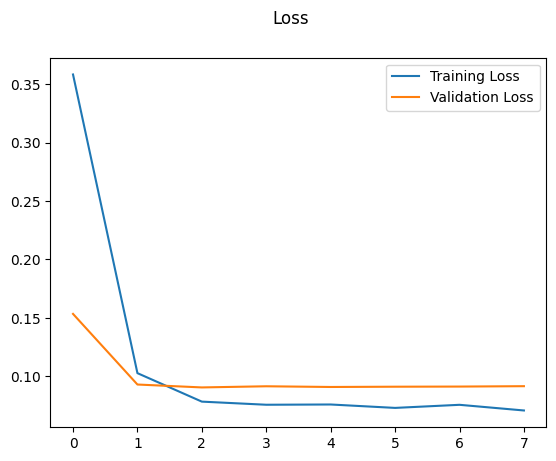

Result:

     Accuracy  F1 Score  Precision    Recall
490  0.979978  0.662861   0.992461  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       497
      Normal       0.98      1.00      0.99     14921
      Replay       0.00      0.00      0.00       315

    accuracy                           0.98     15733
   macro avg       0.66      0.67      0.66     15733
weighted avg       0.96      0.98      0.97     15733



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


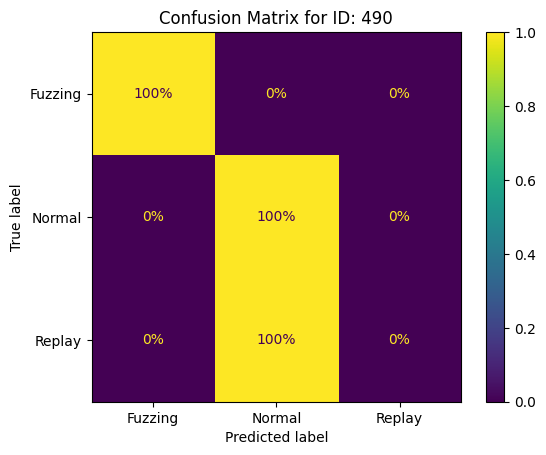

<Figure size 800x600 with 0 Axes>





Processing ID: 593
Epoch 1/100
21/21 [==============================] - 1s 18ms/step - loss: 0.5446 - accuracy: 0.8476 - val_loss: 0.3441 - val_accuracy: 0.8206
Epoch 2/100
21/21 [==============================] - 0s 10ms/step - loss: 0.2322 - accuracy: 0.8966 - val_loss: 0.2024 - val_accuracy: 0.9789
Epoch 3/100
21/21 [==============================] - 0s 10ms/step - loss: 0.1318 - accuracy: 0.9857 - val_loss: 0.1099 - val_accuracy: 0.9842
Epoch 4/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0784 - accuracy: 0.9883 - val_loss: 0.0864 - val_accuracy: 0.9842
Epoch 5/100
21/21 [==============================] - 0s 13ms/step - loss: 0.0741 - accuracy: 0.9883 - val_loss: 0.0812 - val_accuracy: 0.9842
Epoch 6/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0660 - accuracy: 0.9883 - val_loss: 0.0810 - val_accuracy: 0.9842
Epoch 7/100
21/21 [==============================] - 0s 12ms/step - loss: 0.0693 - accuracy: 0.9883 - val_loss: 0.0798 - val_a

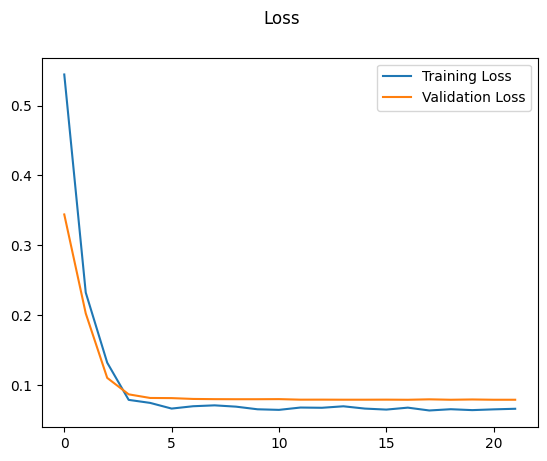

Result:

     Accuracy  F1 Score  Precision    Recall
593  0.220903  0.148635   0.661761  0.374766

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       0.13      1.00      0.23       485
      Normal       0.86      0.12      0.22      3733
      Replay       0.00      0.00      0.00        78

    accuracy                           0.22      4296
   macro avg       0.33      0.37      0.15      4296
weighted avg       0.76      0.22      0.21      4296



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


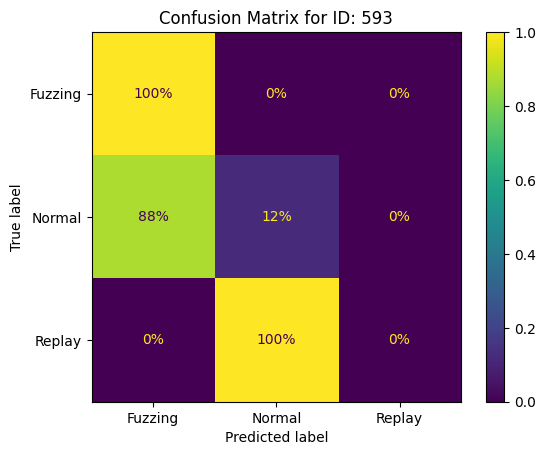

<Figure size 800x600 with 0 Axes>





Processing ID: 484
Epoch 1/100
54/54 [==============================] - 2s 18ms/step - loss: 0.4047 - accuracy: 0.9282 - val_loss: 0.2555 - val_accuracy: 0.9205
Epoch 2/100
54/54 [==============================] - 1s 11ms/step - loss: 0.2125 - accuracy: 0.9390 - val_loss: 0.1700 - val_accuracy: 0.9205
Epoch 3/100
54/54 [==============================] - 1s 11ms/step - loss: 0.1302 - accuracy: 0.9604 - val_loss: 0.1038 - val_accuracy: 0.9708
Epoch 4/100
54/54 [==============================] - 1s 10ms/step - loss: 0.0796 - accuracy: 0.9824 - val_loss: 0.0661 - val_accuracy: 0.9782
Epoch 5/100
54/54 [==============================] - 1s 12ms/step - loss: 0.0661 - accuracy: 0.9844 - val_loss: 0.0518 - val_accuracy: 0.9806
Epoch 6/100
54/54 [==============================] - 1s 11ms/step - loss: 0.0610 - accuracy: 0.9843 - val_loss: 0.0439 - val_accuracy: 0.9820
Epoch 7/100
54/54 [==============================] - 1s 12ms/step - loss: 0.0593 - accuracy: 0.9838 - val_loss: 0.0412 - val_

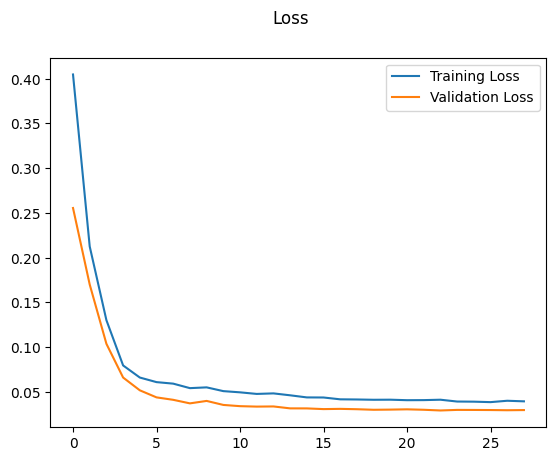

Result:

     Accuracy  F1 Score  Precision    Recall
484  0.979324  0.659659   0.987683  0.665061

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       0.98      1.00      0.99       492
      Normal       0.98      1.00      0.99     10649
      Replay       0.00      0.00      0.00       225

    accuracy                           0.98     11366
   macro avg       0.65      0.67      0.66     11366
weighted avg       0.96      0.98      0.97     11366



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


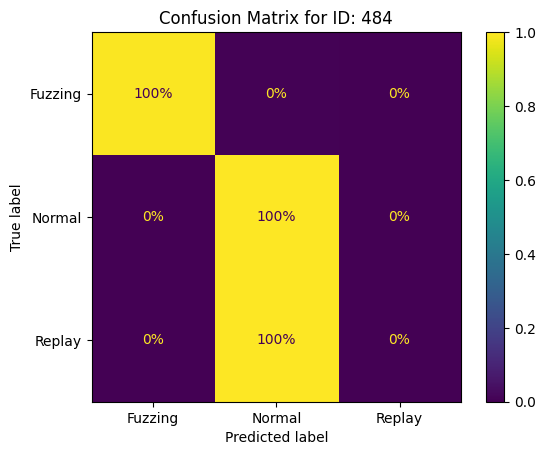

<Figure size 800x600 with 0 Axes>





Processing ID: 48A
Epoch 1/100
75/75 [==============================] - 3s 14ms/step - loss: 0.3929 - accuracy: 0.9256 - val_loss: 0.2332 - val_accuracy: 0.9432
Epoch 2/100
75/75 [==============================] - 1s 10ms/step - loss: 0.1786 - accuracy: 0.9558 - val_loss: 0.1488 - val_accuracy: 0.9720
Epoch 3/100
75/75 [==============================] - 1s 10ms/step - loss: 0.1208 - accuracy: 0.9781 - val_loss: 0.1269 - val_accuracy: 0.9762
Epoch 4/100
75/75 [==============================] - 1s 8ms/step - loss: 0.1098 - accuracy: 0.9801 - val_loss: 0.1207 - val_accuracy: 0.9774
Epoch 5/100
75/75 [==============================] - 1s 7ms/step - loss: 0.1050 - accuracy: 0.9810 - val_loss: 0.1177 - val_accuracy: 0.9784
Epoch 6/100
75/75 [==============================] - 1s 8ms/step - loss: 0.1033 - accuracy: 0.9814 - val_loss: 0.1177 - val_accuracy: 0.9784
Epoch 7/100
75/75 [==============================] - 1s 7ms/step - loss: 0.1046 - accuracy: 0.9814 - val_loss: 0.1162 - val_accu

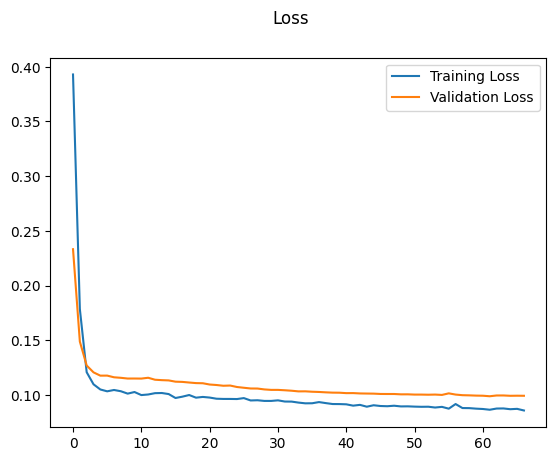

Result:

     Accuracy  F1 Score  Precision    Recall
48A  0.976104   0.64068   0.991808  0.625672

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.88      0.93       496
      Normal       0.98      1.00      0.99     14924
      Replay       0.00      0.00      0.00       315

    accuracy                           0.98     15735
   macro avg       0.66      0.63      0.64     15735
weighted avg       0.96      0.98      0.97     15735



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


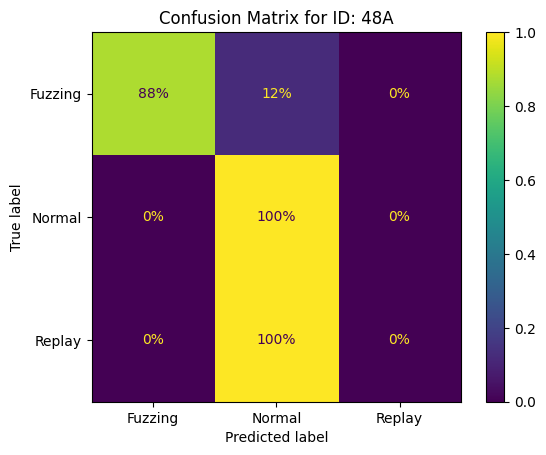

<Figure size 800x600 with 0 Axes>





Processing ID: 50C
Epoch 1/100
39/39 [==============================] - 3s 22ms/step - loss: 0.6238 - accuracy: 0.8622 - val_loss: 0.2914 - val_accuracy: 0.9022
Epoch 2/100
39/39 [==============================] - 0s 10ms/step - loss: 0.1699 - accuracy: 0.9546 - val_loss: 0.1082 - val_accuracy: 0.9815
Epoch 3/100
39/39 [==============================] - 0s 12ms/step - loss: 0.0821 - accuracy: 0.9860 - val_loss: 0.0756 - val_accuracy: 0.9824
Epoch 4/100
39/39 [==============================] - 0s 11ms/step - loss: 0.0740 - accuracy: 0.9868 - val_loss: 0.0736 - val_accuracy: 0.9824
Epoch 5/100
39/39 [==============================] - 0s 11ms/step - loss: 0.0702 - accuracy: 0.9870 - val_loss: 0.0716 - val_accuracy: 0.9824
Epoch 6/100
39/39 [==============================] - 0s 11ms/step - loss: 0.0682 - accuracy: 0.9870 - val_loss: 0.0690 - val_accuracy: 0.9824
Epoch 7/100
39/39 [==============================] - 0s 11ms/step - loss: 0.0686 - accuracy: 0.9870 - val_loss: 0.0675 - val_

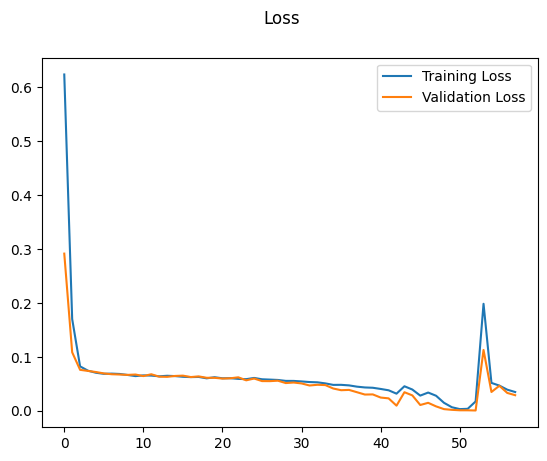

Result:

     Accuracy  F1 Score  Precision    Recall
50C   0.99963  0.998922   0.999866  0.997984

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.99      1.00       496
      Normal       1.00      1.00      1.00      7452
      Replay       1.00      1.00      1.00       158

    accuracy                           1.00      8106
   macro avg       1.00      1.00      1.00      8106
weighted avg       1.00      1.00      1.00      8106



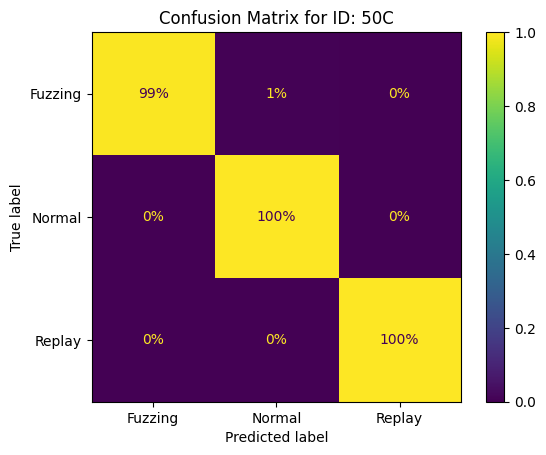

<Figure size 800x600 with 0 Axes>





Processing ID: 58B
Epoch 1/100
75/75 [==============================] - 2s 10ms/step - loss: 0.4069 - accuracy: 0.9434 - val_loss: 0.1423 - val_accuracy: 0.9658
Epoch 2/100
75/75 [==============================] - 1s 9ms/step - loss: 0.0912 - accuracy: 0.9824 - val_loss: 0.0905 - val_accuracy: 0.9818
Epoch 3/100
75/75 [==============================] - 1s 11ms/step - loss: 0.0726 - accuracy: 0.9867 - val_loss: 0.0878 - val_accuracy: 0.9818
Epoch 4/100
75/75 [==============================] - 1s 12ms/step - loss: 0.0712 - accuracy: 0.9867 - val_loss: 0.0872 - val_accuracy: 0.9818
Epoch 5/100
75/75 [==============================] - 1s 11ms/step - loss: 0.0709 - accuracy: 0.9867 - val_loss: 0.0861 - val_accuracy: 0.9818
Epoch 6/100
75/75 [==============================] - 1s 10ms/step - loss: 0.0710 - accuracy: 0.9867 - val_loss: 0.0869 - val_accuracy: 0.9818
Epoch 7/100
75/75 [==============================] - 1s 13ms/step - loss: 0.0698 - accuracy: 0.9867 - val_loss: 0.0866 - val_a

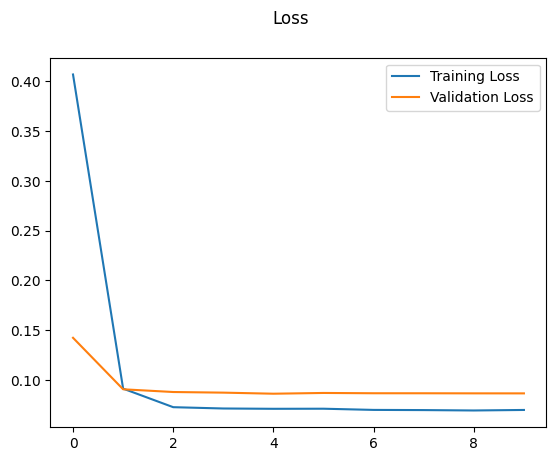

Result:

     Accuracy  F1 Score  Precision    Recall
58B  0.980019  0.663185   0.993108  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       530
      Normal       0.98      1.00      0.99     14920
      Replay       0.00      0.00      0.00       315

    accuracy                           0.98     15765
   macro avg       0.66      0.67      0.66     15765
weighted avg       0.96      0.98      0.97     15765



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


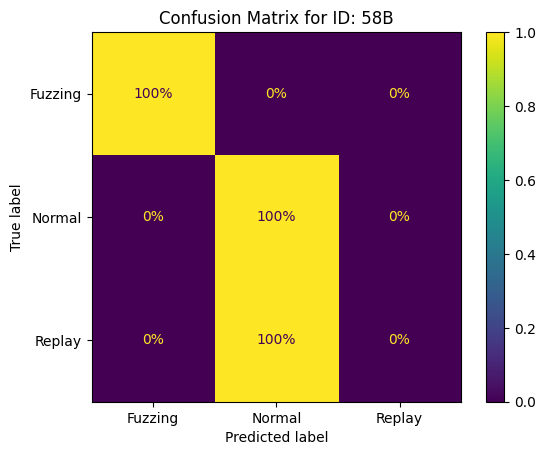

<Figure size 800x600 with 0 Axes>





Processing ID: 436
Epoch 1/100
74/74 [==============================] - 2s 10ms/step - loss: 0.3892 - accuracy: 0.9519 - val_loss: 0.1379 - val_accuracy: 0.9785
Epoch 2/100
74/74 [==============================] - 1s 8ms/step - loss: 0.0947 - accuracy: 0.9861 - val_loss: 0.0934 - val_accuracy: 0.9819
Epoch 3/100
74/74 [==============================] - 1s 8ms/step - loss: 0.0818 - accuracy: 0.9866 - val_loss: 0.0910 - val_accuracy: 0.9819
Epoch 4/100
74/74 [==============================] - 1s 8ms/step - loss: 0.0806 - accuracy: 0.9866 - val_loss: 0.0905 - val_accuracy: 0.9819
Epoch 5/100
74/74 [==============================] - 1s 8ms/step - loss: 0.0805 - accuracy: 0.9866 - val_loss: 0.0903 - val_accuracy: 0.9819
Epoch 6/100
74/74 [==============================] - 1s 8ms/step - loss: 0.0786 - accuracy: 0.9866 - val_loss: 0.0903 - val_accuracy: 0.9819
Epoch 7/100
74/74 [==============================] - 1s 8ms/step - loss: 0.0813 - accuracy: 0.9866 - val_loss: 0.0902 - val_accura

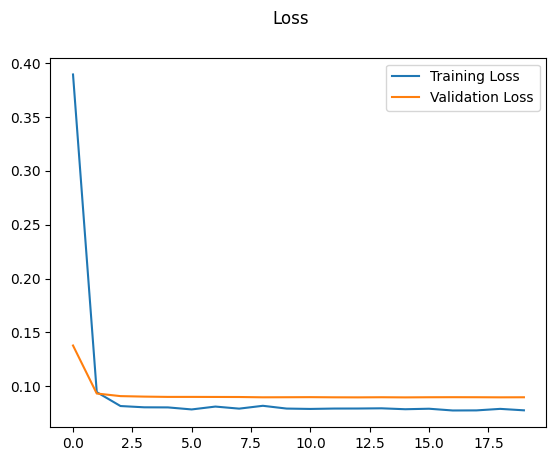

Result:

     Accuracy  F1 Score  Precision    Recall
436  0.979917  0.663173   0.993085  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       503
      Normal       0.98      1.00      0.99     14916
      Replay       0.00      0.00      0.00       316

    accuracy                           0.98     15735
   macro avg       0.66      0.67      0.66     15735
weighted avg       0.96      0.98      0.97     15735



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


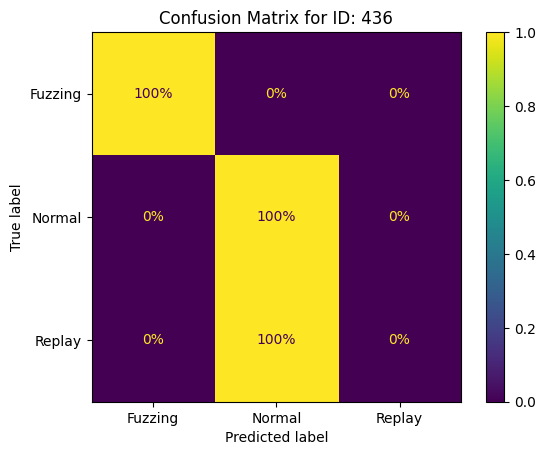

<Figure size 800x600 with 0 Axes>





Processing ID: 541
Epoch 1/100
41/41 [==============================] - 2s 13ms/step - loss: 0.3712 - accuracy: 0.9182 - val_loss: 0.1588 - val_accuracy: 0.9808
Epoch 2/100
41/41 [==============================] - 0s 11ms/step - loss: 0.0999 - accuracy: 0.9874 - val_loss: 0.0940 - val_accuracy: 0.9835
Epoch 3/100
41/41 [==============================] - 1s 13ms/step - loss: 0.0762 - accuracy: 0.9879 - val_loss: 0.0869 - val_accuracy: 0.9835
Epoch 4/100
41/41 [==============================] - 1s 13ms/step - loss: 0.0728 - accuracy: 0.9879 - val_loss: 0.0851 - val_accuracy: 0.9835
Epoch 5/100
41/41 [==============================] - 0s 11ms/step - loss: 0.0721 - accuracy: 0.9879 - val_loss: 0.0843 - val_accuracy: 0.9835
Epoch 6/100
41/41 [==============================] - 0s 11ms/step - loss: 0.0717 - accuracy: 0.9879 - val_loss: 0.0839 - val_accuracy: 0.9835
Epoch 7/100
41/41 [==============================] - 1s 13ms/step - loss: 0.0698 - accuracy: 0.9879 - val_loss: 0.0836 - val_

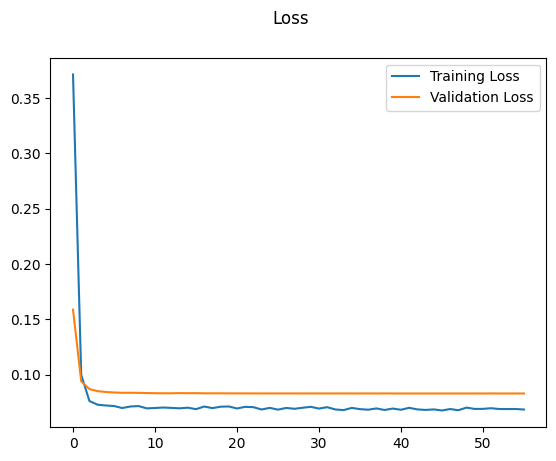

Result:

     Accuracy  F1 Score  Precision    Recall
541  0.981634  0.663376   0.993483  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       521
      Normal       0.98      1.00      0.99      7924
      Replay       0.00      0.00      0.00       158

    accuracy                           0.98      8603
   macro avg       0.66      0.67      0.66      8603
weighted avg       0.96      0.98      0.97      8603



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


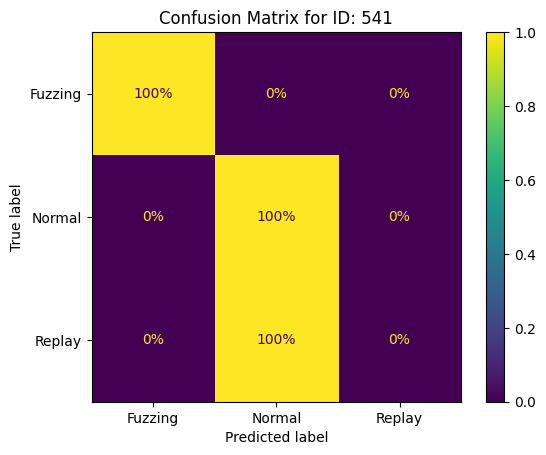

<Figure size 800x600 with 0 Axes>





Processing ID: 507
Epoch 1/100
39/39 [==============================] - 2s 14ms/step - loss: 0.6192 - accuracy: 0.9014 - val_loss: 0.2681 - val_accuracy: 0.9088
Epoch 2/100
39/39 [==============================] - 0s 10ms/step - loss: 0.1727 - accuracy: 0.9466 - val_loss: 0.1339 - val_accuracy: 0.9829
Epoch 3/100
39/39 [==============================] - 0s 9ms/step - loss: 0.0918 - accuracy: 0.9870 - val_loss: 0.0926 - val_accuracy: 0.9829
Epoch 4/100
39/39 [==============================] - 0s 12ms/step - loss: 0.0716 - accuracy: 0.9872 - val_loss: 0.0856 - val_accuracy: 0.9829
Epoch 5/100
39/39 [==============================] - 0s 10ms/step - loss: 0.0667 - accuracy: 0.9872 - val_loss: 0.0834 - val_accuracy: 0.9829
Epoch 6/100
39/39 [==============================] - 0s 11ms/step - loss: 0.0672 - accuracy: 0.9872 - val_loss: 0.0820 - val_accuracy: 0.9829
Epoch 7/100
39/39 [==============================] - 0s 10ms/step - loss: 0.0662 - accuracy: 0.9870 - val_loss: 0.0814 - val_a

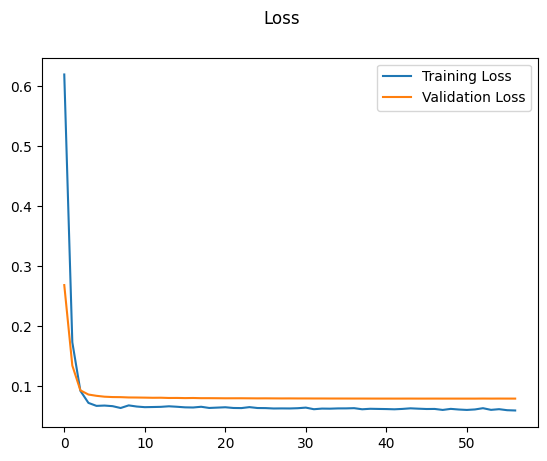

Result:

     Accuracy  F1 Score  Precision    Recall
507  0.980563  0.663172   0.993084  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       514
      Normal       0.98      1.00      0.99      7457
      Replay       0.00      0.00      0.00       158

    accuracy                           0.98      8129
   macro avg       0.66      0.67      0.66      8129
weighted avg       0.96      0.98      0.97      8129



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


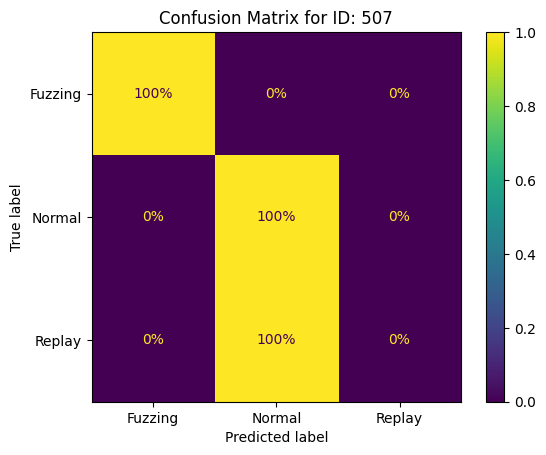

<Figure size 800x600 with 0 Axes>





Processing ID: 4A7
Epoch 1/100
10/10 [==============================] - 2s 45ms/step - loss: 0.9853 - accuracy: 0.6595 - val_loss: 0.8171 - val_accuracy: 0.8253
Epoch 2/100
10/10 [==============================] - 0s 18ms/step - loss: 0.6592 - accuracy: 0.7990 - val_loss: 0.4978 - val_accuracy: 0.8253
Epoch 3/100
10/10 [==============================] - 0s 13ms/step - loss: 0.3582 - accuracy: 0.8708 - val_loss: 0.2455 - val_accuracy: 0.9870
Epoch 4/100
10/10 [==============================] - 0s 14ms/step - loss: 0.1585 - accuracy: 0.9864 - val_loss: 0.1125 - val_accuracy: 0.9870
Epoch 5/100
10/10 [==============================] - 0s 14ms/step - loss: 0.0891 - accuracy: 0.9896 - val_loss: 0.0937 - val_accuracy: 0.9870
Epoch 6/100
10/10 [==============================] - 0s 13ms/step - loss: 0.0758 - accuracy: 0.9896 - val_loss: 0.0847 - val_accuracy: 0.9870
Epoch 7/100
10/10 [==============================] - 0s 14ms/step - loss: 0.0696 - accuracy: 0.9896 - val_loss: 0.0751 - val_

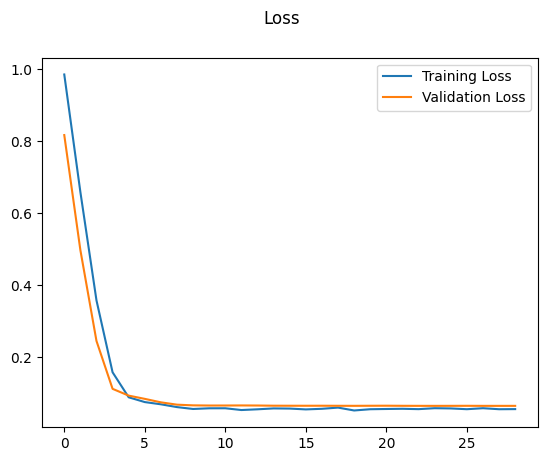

Result:

     Accuracy  F1 Score  Precision    Recall
4A7  0.984064   0.66313   0.993001  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       484
      Normal       0.98      1.00      0.99      1492
      Replay       0.00      0.00      0.00        32

    accuracy                           0.98      2008
   macro avg       0.66      0.67      0.66      2008
weighted avg       0.97      0.98      0.98      2008



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


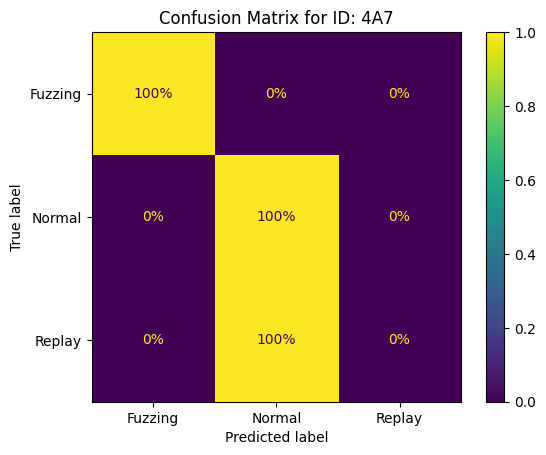

<Figure size 800x600 with 0 Axes>





Processing ID: 520
Epoch 1/100
39/39 [==============================] - 2s 14ms/step - loss: 0.9656 - accuracy: 0.9271 - val_loss: 0.5179 - val_accuracy: 0.9432
Epoch 2/100
39/39 [==============================] - 0s 9ms/step - loss: 0.2150 - accuracy: 0.9596 - val_loss: 0.1236 - val_accuracy: 0.9811
Epoch 3/100
39/39 [==============================] - 0s 9ms/step - loss: 0.0908 - accuracy: 0.9866 - val_loss: 0.0957 - val_accuracy: 0.9825
Epoch 4/100
39/39 [==============================] - 0s 10ms/step - loss: 0.0756 - accuracy: 0.9868 - val_loss: 0.0900 - val_accuracy: 0.9825
Epoch 5/100
39/39 [==============================] - 0s 9ms/step - loss: 0.0748 - accuracy: 0.9870 - val_loss: 0.0876 - val_accuracy: 0.9825
Epoch 6/100
39/39 [==============================] - 0s 10ms/step - loss: 0.0746 - accuracy: 0.9870 - val_loss: 0.0865 - val_accuracy: 0.9825
Epoch 7/100
39/39 [==============================] - 0s 11ms/step - loss: 0.0737 - accuracy: 0.9870 - val_loss: 0.0864 - val_acc

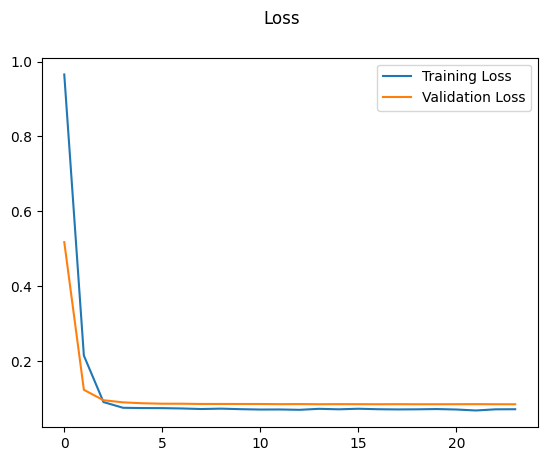

Result:

     Accuracy  F1 Score  Precision    Recall
520  0.980477  0.663161   0.993062  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       502
      Normal       0.98      1.00      0.99      7433
      Replay       0.00      0.00      0.00       158

    accuracy                           0.98      8093
   macro avg       0.66      0.67      0.66      8093
weighted avg       0.96      0.98      0.97      8093



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


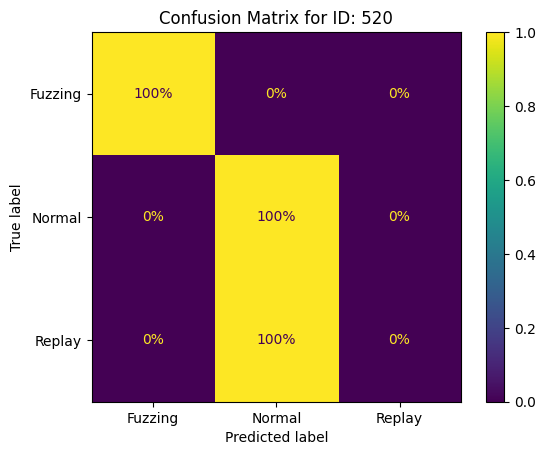

<Figure size 800x600 with 0 Axes>





Processing ID: 53E
Epoch 1/100
39/39 [==============================] - 2s 13ms/step - loss: 0.4942 - accuracy: 0.8776 - val_loss: 0.2652 - val_accuracy: 0.8987
Epoch 2/100
39/39 [==============================] - 0s 10ms/step - loss: 0.1589 - accuracy: 0.9509 - val_loss: 0.1377 - val_accuracy: 0.9782
Epoch 3/100
39/39 [==============================] - 0s 9ms/step - loss: 0.0848 - accuracy: 0.9858 - val_loss: 0.0977 - val_accuracy: 0.9820
Epoch 4/100
39/39 [==============================] - 0s 10ms/step - loss: 0.0702 - accuracy: 0.9868 - val_loss: 0.0924 - val_accuracy: 0.9825
Epoch 5/100
39/39 [==============================] - 0s 10ms/step - loss: 0.0696 - accuracy: 0.9868 - val_loss: 0.0908 - val_accuracy: 0.9825
Epoch 6/100
39/39 [==============================] - 0s 9ms/step - loss: 0.0686 - accuracy: 0.9870 - val_loss: 0.0896 - val_accuracy: 0.9825
Epoch 7/100
39/39 [==============================] - 0s 11ms/step - loss: 0.0679 - accuracy: 0.9872 - val_loss: 0.0889 - val_ac

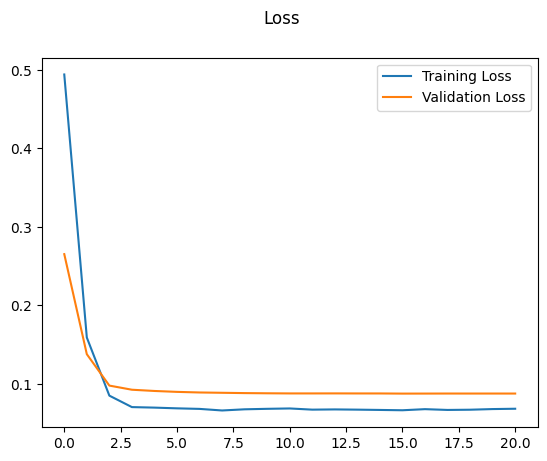

Result:

     Accuracy  F1 Score  Precision    Recall
53E  0.980677  0.663195   0.993128  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       510
      Normal       0.98      1.00      0.99      7458
      Replay       0.00      0.00      0.00       157

    accuracy                           0.98      8125
   macro avg       0.66      0.67      0.66      8125
weighted avg       0.96      0.98      0.97      8125



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


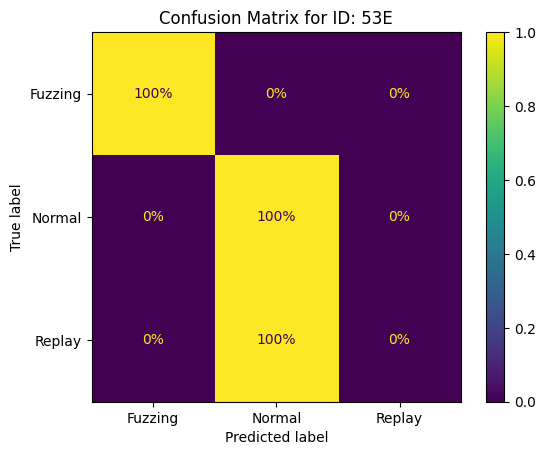

<Figure size 800x600 with 0 Axes>





Processing ID: 495
Epoch 1/100
38/38 [==============================] - 2s 14ms/step - loss: 0.6919 - accuracy: 0.8641 - val_loss: 0.4308 - val_accuracy: 0.9078
Epoch 2/100
38/38 [==============================] - 0s 9ms/step - loss: 0.3362 - accuracy: 0.9275 - val_loss: 0.3712 - val_accuracy: 0.9078
Epoch 3/100
38/38 [==============================] - 0s 10ms/step - loss: 0.3273 - accuracy: 0.9275 - val_loss: 0.3703 - val_accuracy: 0.9078
Epoch 4/100
38/38 [==============================] - 0s 9ms/step - loss: 0.3221 - accuracy: 0.9275 - val_loss: 0.3680 - val_accuracy: 0.9078
Epoch 5/100
38/38 [==============================] - 0s 10ms/step - loss: 0.3220 - accuracy: 0.9275 - val_loss: 0.3662 - val_accuracy: 0.9078
Epoch 6/100
38/38 [==============================] - 0s 11ms/step - loss: 0.3169 - accuracy: 0.9275 - val_loss: 0.3639 - val_accuracy: 0.9078
Epoch 7/100
38/38 [==============================] - 0s 10ms/step - loss: 0.3149 - accuracy: 0.9275 - val_loss: 0.3610 - val_ac

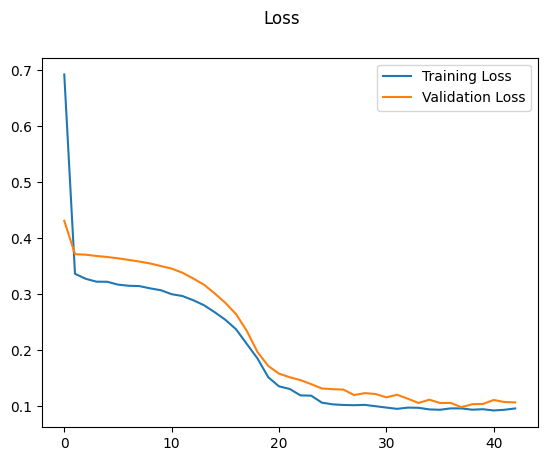

Result:

     Accuracy  F1 Score  Precision    Recall
495  0.976724  0.651022   0.991801  0.644444

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.93      0.97       465
      Normal       0.98      1.00      0.99      7455
      Replay       0.00      0.00      0.00       157

    accuracy                           0.98      8077
   macro avg       0.66      0.64      0.65      8077
weighted avg       0.96      0.98      0.97      8077



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


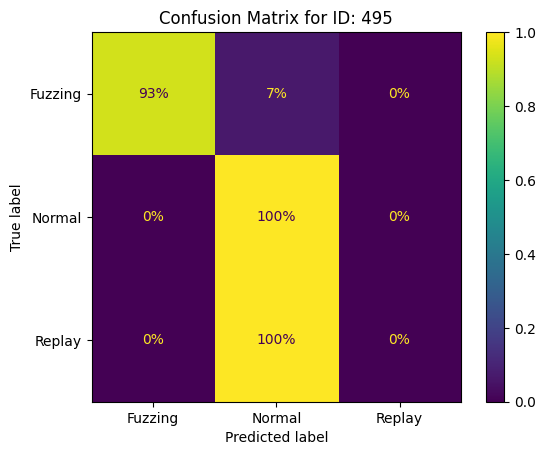

<Figure size 800x600 with 0 Axes>





Processing ID: 500
Epoch 1/100
39/39 [==============================] - 2s 13ms/step - loss: 0.6129 - accuracy: 0.9211 - val_loss: 0.3496 - val_accuracy: 0.9052
Epoch 2/100
39/39 [==============================] - 0s 12ms/step - loss: 0.2342 - accuracy: 0.9386 - val_loss: 0.2060 - val_accuracy: 0.9602
Epoch 3/100
39/39 [==============================] - 0s 10ms/step - loss: 0.1438 - accuracy: 0.9762 - val_loss: 0.1332 - val_accuracy: 0.9751
Epoch 4/100
39/39 [==============================] - 0s 9ms/step - loss: 0.1038 - accuracy: 0.9825 - val_loss: 0.1154 - val_accuracy: 0.9780
Epoch 5/100
39/39 [==============================] - 0s 10ms/step - loss: 0.0954 - accuracy: 0.9840 - val_loss: 0.1100 - val_accuracy: 0.9799
Epoch 6/100
39/39 [==============================] - 0s 10ms/step - loss: 0.0934 - accuracy: 0.9848 - val_loss: 0.1051 - val_accuracy: 0.9799
Epoch 7/100
39/39 [==============================] - 0s 10ms/step - loss: 0.0870 - accuracy: 0.9850 - val_loss: 0.1020 - val_a

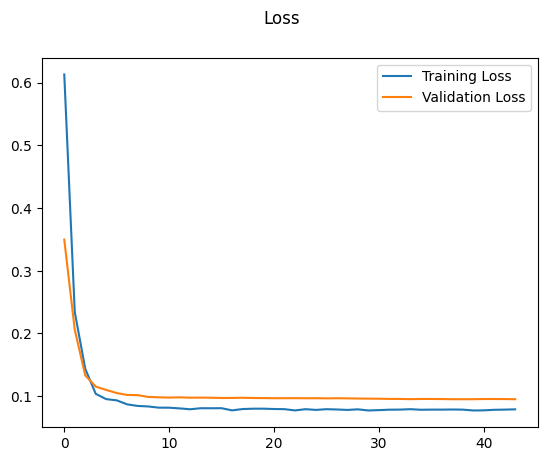

Result:

     Accuracy  F1 Score  Precision    Recall
500  0.978242  0.656377   0.992259  0.654159

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.96      0.98       533
      Normal       0.98      1.00      0.99      7445
      Replay       0.00      0.00      0.00       157

    accuracy                           0.98      8135
   macro avg       0.66      0.65      0.66      8135
weighted avg       0.96      0.98      0.97      8135



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


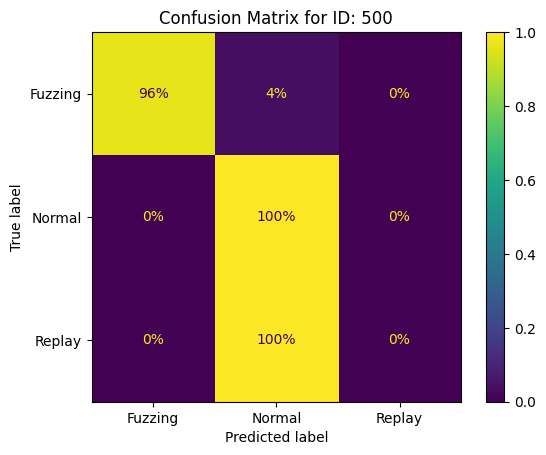

<Figure size 800x600 with 0 Axes>





Processing ID: 483
Epoch 1/100
22/22 [==============================] - 2s 19ms/step - loss: 0.9346 - accuracy: 0.7010 - val_loss: 0.6514 - val_accuracy: 0.8424
Epoch 2/100
22/22 [==============================] - 0s 12ms/step - loss: 0.4566 - accuracy: 0.8730 - val_loss: 0.5277 - val_accuracy: 0.8424
Epoch 3/100
22/22 [==============================] - 0s 14ms/step - loss: 0.4054 - accuracy: 0.8730 - val_loss: 0.4794 - val_accuracy: 0.8424
Epoch 4/100
22/22 [==============================] - 0s 12ms/step - loss: 0.3693 - accuracy: 0.8774 - val_loss: 0.4431 - val_accuracy: 0.8674
Epoch 5/100
22/22 [==============================] - 0s 14ms/step - loss: 0.3424 - accuracy: 0.9018 - val_loss: 0.4055 - val_accuracy: 0.8898
Epoch 6/100
22/22 [==============================] - 0s 14ms/step - loss: 0.3156 - accuracy: 0.9188 - val_loss: 0.3655 - val_accuracy: 0.9018
Epoch 7/100
22/22 [==============================] - 0s 15ms/step - loss: 0.2900 - accuracy: 0.9262 - val_loss: 0.3332 - val_

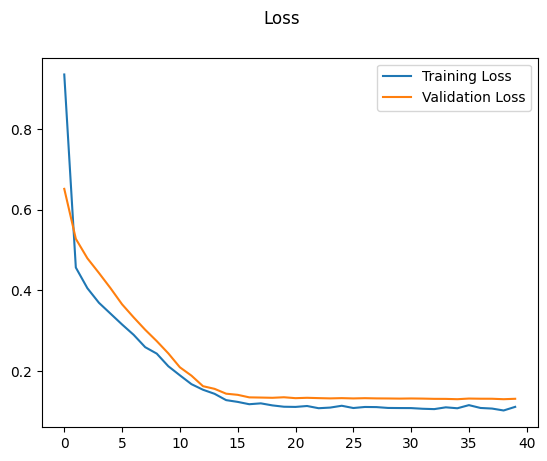

Result:

     Accuracy  F1 Score  Precision    Recall
483  0.972761  0.648086   0.989828  0.640873

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.92      0.96       504
      Normal       0.97      1.00      0.98      3749
      Replay       0.00      0.00      0.00        79

    accuracy                           0.97      4332
   macro avg       0.66      0.64      0.65      4332
weighted avg       0.96      0.97      0.96      4332



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


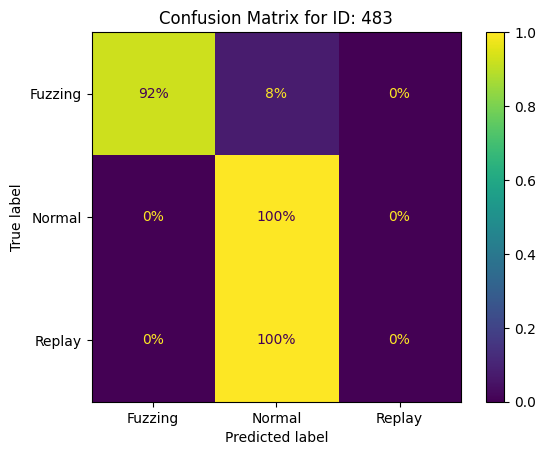

<Figure size 800x600 with 0 Axes>





Processing ID: 4A2
Epoch 1/100
11/11 [==============================] - 2s 46ms/step - loss: 1.0655 - accuracy: 0.7267 - val_loss: 0.9678 - val_accuracy: 0.9873
Epoch 2/100
11/11 [==============================] - 0s 14ms/step - loss: 0.8760 - accuracy: 0.9775 - val_loss: 0.6736 - val_accuracy: 0.9873
Epoch 3/100
11/11 [==============================] - 0s 19ms/step - loss: 0.5405 - accuracy: 0.9868 - val_loss: 0.2601 - val_accuracy: 0.9873
Epoch 4/100
11/11 [==============================] - 0s 23ms/step - loss: 0.1735 - accuracy: 0.9899 - val_loss: 0.0805 - val_accuracy: 0.9873
Epoch 5/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0684 - accuracy: 0.9899 - val_loss: 0.0825 - val_accuracy: 0.9873
Epoch 6/100
11/11 [==============================] - 0s 14ms/step - loss: 0.0714 - accuracy: 0.9899 - val_loss: 0.0833 - val_accuracy: 0.9873
Epoch 7/100
11/11 [==============================] - 0s 17ms/step - loss: 0.0627 - accuracy: 0.9899 - val_loss: 0.0769 - val_

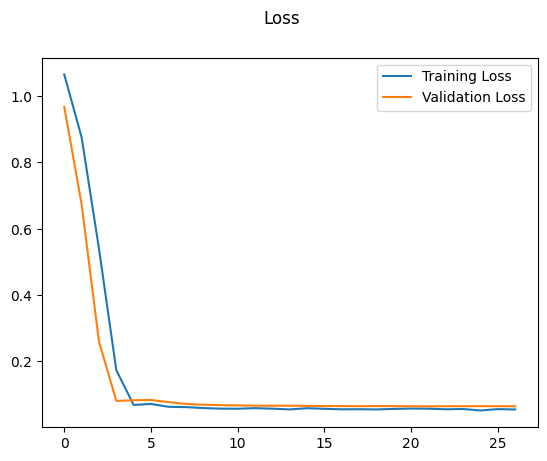

Result:

     Accuracy  F1 Score  Precision    Recall
4A2   0.98426  0.663121   0.992982  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       513
      Normal       0.98      1.00      0.99      1488
      Replay       0.00      0.00      0.00        32

    accuracy                           0.98      2033
   macro avg       0.66      0.67      0.66      2033
weighted avg       0.97      0.98      0.98      2033



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


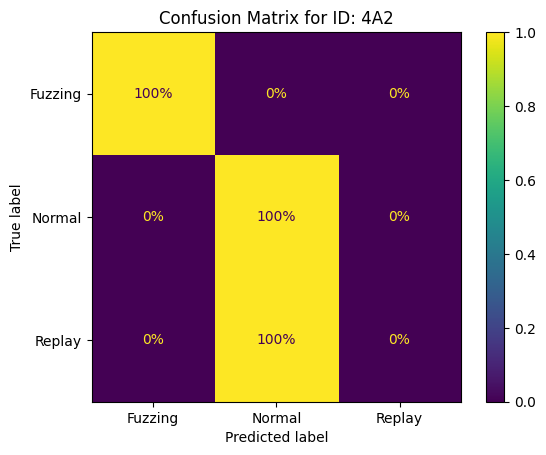

<Figure size 800x600 with 0 Axes>





Processing ID: 50A
Epoch 1/100
26/26 [==============================] - 3s 21ms/step - loss: 0.6525 - accuracy: 0.8215 - val_loss: 0.3740 - val_accuracy: 0.8631
Epoch 2/100
26/26 [==============================] - 0s 12ms/step - loss: 0.2790 - accuracy: 0.8898 - val_loss: 0.2271 - val_accuracy: 0.9327
Epoch 3/100
26/26 [==============================] - 0s 12ms/step - loss: 0.1699 - accuracy: 0.9621 - val_loss: 0.1260 - val_accuracy: 0.9783
Epoch 4/100
26/26 [==============================] - 0s 14ms/step - loss: 0.0986 - accuracy: 0.9839 - val_loss: 0.0876 - val_accuracy: 0.9812
Epoch 5/100
26/26 [==============================] - 0s 13ms/step - loss: 0.0788 - accuracy: 0.9860 - val_loss: 0.0830 - val_accuracy: 0.9819
Epoch 6/100
26/26 [==============================] - 0s 12ms/step - loss: 0.0754 - accuracy: 0.9867 - val_loss: 0.0790 - val_accuracy: 0.9833
Epoch 7/100
26/26 [==============================] - 0s 16ms/step - loss: 0.0722 - accuracy: 0.9879 - val_loss: 0.0786 - val_

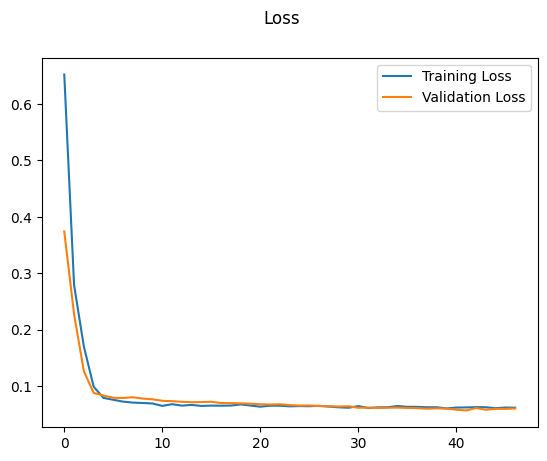

Result:

     Accuracy  F1 Score  Precision    Recall
50A  0.984364   0.66149   0.994257  0.662136

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.99      0.99       515
      Normal       0.98      1.00      0.99      4906
      Replay       0.00      0.00      0.00        79

    accuracy                           0.98      5500
   macro avg       0.66      0.66      0.66      5500
weighted avg       0.97      0.98      0.98      5500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


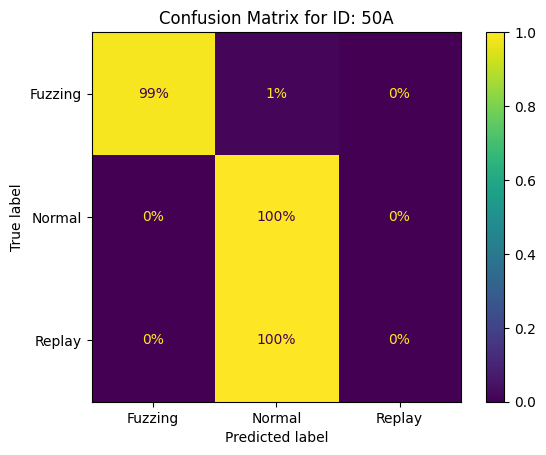

<Figure size 800x600 with 0 Axes>





Processing ID: 043
Epoch 1/100
10/10 [==============================] - 2s 40ms/step - loss: 0.9391 - accuracy: 0.5186 - val_loss: 0.6282 - val_accuracy: 0.6532
Epoch 2/100
10/10 [==============================] - 0s 15ms/step - loss: 0.5499 - accuracy: 0.5870 - val_loss: 0.3911 - val_accuracy: 0.6532
Epoch 3/100
10/10 [==============================] - 0s 20ms/step - loss: 0.4403 - accuracy: 0.5887 - val_loss: 0.3215 - val_accuracy: 0.9919
Epoch 4/100
10/10 [==============================] - 0s 16ms/step - loss: 0.3438 - accuracy: 0.8987 - val_loss: 0.2277 - val_accuracy: 0.9919
Epoch 5/100
10/10 [==============================] - 0s 16ms/step - loss: 0.2180 - accuracy: 0.9939 - val_loss: 0.1219 - val_accuracy: 0.9919
Epoch 6/100
10/10 [==============================] - 0s 16ms/step - loss: 0.1016 - accuracy: 0.9931 - val_loss: 0.0608 - val_accuracy: 0.9919
Epoch 7/100
10/10 [==============================] - 0s 16ms/step - loss: 0.0450 - accuracy: 0.9939 - val_loss: 0.0470 - val_

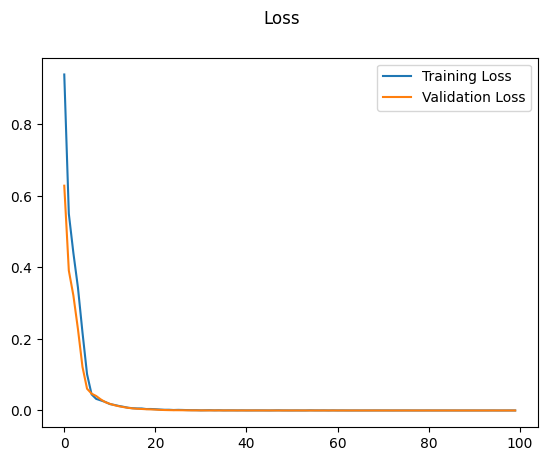

Result:

     Accuracy  F1 Score  Precision    Recall
043  0.993096  0.843498    0.99473  0.789474

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       972
      Normal       0.98      1.00      0.99       747
      Replay       1.00      0.37      0.54        19

    accuracy                           0.99      1738
   macro avg       0.99      0.79      0.84      1738
weighted avg       0.99      0.99      0.99      1738



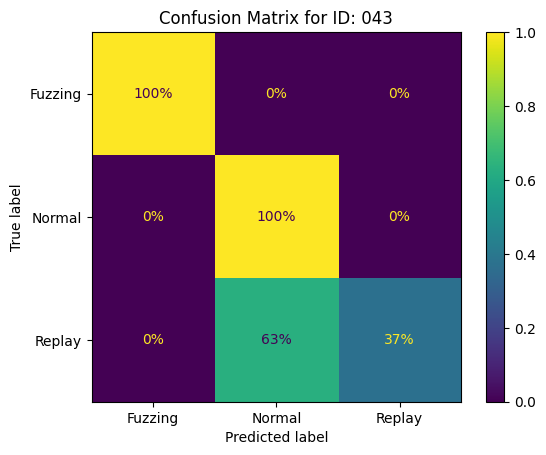

<Figure size 800x600 with 0 Axes>





Processing ID: 52A
Epoch 1/100
44/44 [==============================] - 3s 21ms/step - loss: 0.3431 - accuracy: 0.9274 - val_loss: 0.1445 - val_accuracy: 0.9711
Epoch 2/100
44/44 [==============================] - 1s 15ms/step - loss: 0.0641 - accuracy: 0.9910 - val_loss: 0.0766 - val_accuracy: 0.9879
Epoch 3/100
44/44 [==============================] - 1s 16ms/step - loss: 0.0407 - accuracy: 0.9943 - val_loss: 0.0682 - val_accuracy: 0.9879
Epoch 4/100
44/44 [==============================] - 1s 14ms/step - loss: 0.0399 - accuracy: 0.9943 - val_loss: 0.0666 - val_accuracy: 0.9879
Epoch 5/100
44/44 [==============================] - 1s 14ms/step - loss: 0.0382 - accuracy: 0.9943 - val_loss: 0.0655 - val_accuracy: 0.9879
Epoch 6/100
44/44 [==============================] - 1s 14ms/step - loss: 0.0377 - accuracy: 0.9943 - val_loss: 0.0649 - val_accuracy: 0.9879
Epoch 7/100
44/44 [==============================] - 1s 16ms/step - loss: 0.0371 - accuracy: 0.9943 - val_loss: 0.0649 - val_

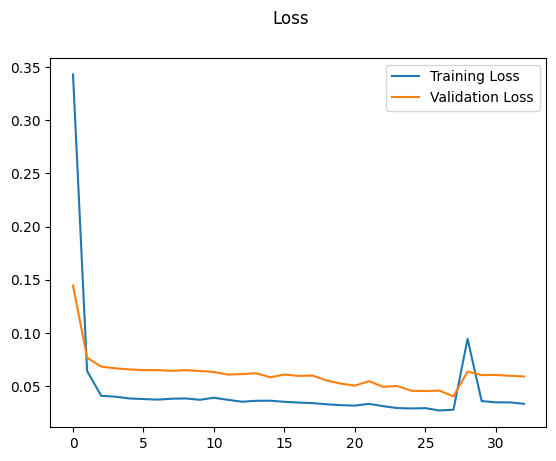

Result:

     Accuracy  F1 Score  Precision    Recall
52A  0.986878  0.664342   0.995383  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       482
      Normal       0.99      1.00      0.99      8543
      Replay       0.00      0.00      0.00       120

    accuracy                           0.99      9145
   macro avg       0.66      0.67      0.66      9145
weighted avg       0.97      0.99      0.98      9145



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


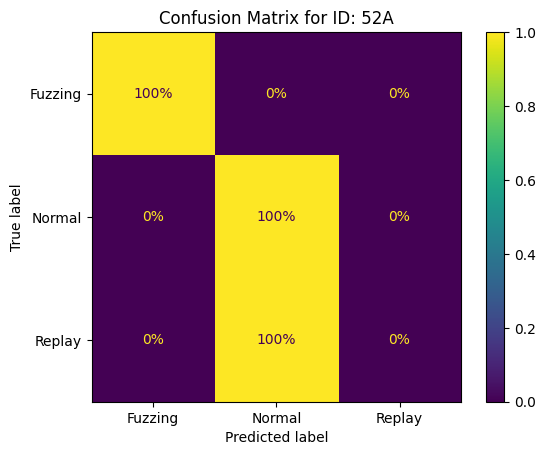

<Figure size 800x600 with 0 Axes>





Processing ID: 544
Epoch 1/100
21/21 [==============================] - 1s 19ms/step - loss: 0.6593 - accuracy: 0.8095 - val_loss: 0.4168 - val_accuracy: 0.8374
Epoch 2/100
21/21 [==============================] - 0s 12ms/step - loss: 0.3537 - accuracy: 0.8674 - val_loss: 0.3519 - val_accuracy: 0.8374
Epoch 3/100
21/21 [==============================] - 0s 11ms/step - loss: 0.2877 - accuracy: 0.8701 - val_loss: 0.3037 - val_accuracy: 0.8534
Epoch 4/100
21/21 [==============================] - 0s 13ms/step - loss: 0.2306 - accuracy: 0.9256 - val_loss: 0.2362 - val_accuracy: 0.9526
Epoch 5/100
21/21 [==============================] - 0s 12ms/step - loss: 0.1653 - accuracy: 0.9701 - val_loss: 0.1537 - val_accuracy: 0.9696
Epoch 6/100
21/21 [==============================] - 0s 11ms/step - loss: 0.1173 - accuracy: 0.9797 - val_loss: 0.1245 - val_accuracy: 0.9741
Epoch 7/100
21/21 [==============================] - 0s 12ms/step - loss: 0.0983 - accuracy: 0.9820 - val_loss: 0.1146 - val_

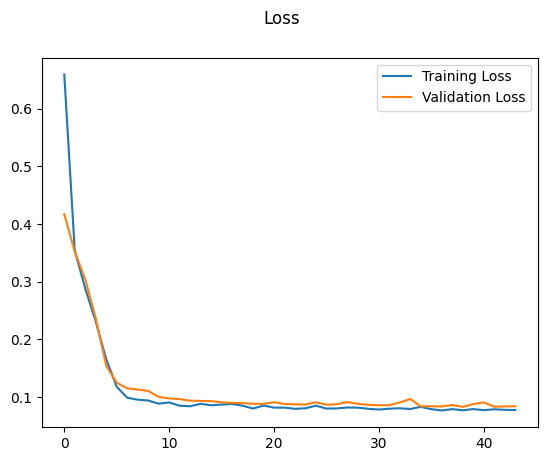

Result:

     Accuracy  F1 Score  Precision    Recall
544  0.979355  0.659444   0.992209  0.660169

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.98      0.99       513
      Normal       0.98      1.00      0.99      3719
      Replay       0.00      0.00      0.00        79

    accuracy                           0.98      4311
   macro avg       0.66      0.66      0.66      4311
weighted avg       0.96      0.98      0.97      4311



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


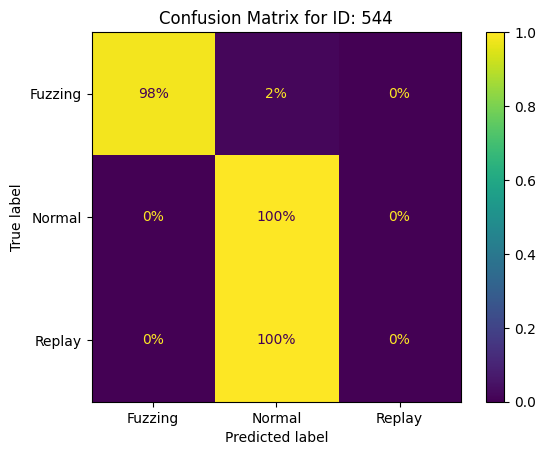

<Figure size 800x600 with 0 Axes>





Processing ID: 559
Epoch 1/100
21/21 [==============================] - 2s 24ms/step - loss: 1.0136 - accuracy: 0.9269 - val_loss: 0.8858 - val_accuracy: 0.9840
Epoch 2/100
21/21 [==============================] - 0s 13ms/step - loss: 0.8055 - accuracy: 0.9878 - val_loss: 0.5785 - val_accuracy: 0.9840
Epoch 3/100
21/21 [==============================] - 0s 10ms/step - loss: 0.3217 - accuracy: 0.9855 - val_loss: 0.1157 - val_accuracy: 0.9840
Epoch 4/100
21/21 [==============================] - 0s 12ms/step - loss: 0.0968 - accuracy: 0.9878 - val_loss: 0.1155 - val_accuracy: 0.9840
Epoch 5/100
21/21 [==============================] - 0s 11ms/step - loss: 0.0868 - accuracy: 0.9878 - val_loss: 0.0984 - val_accuracy: 0.9840
Epoch 6/100
21/21 [==============================] - 0s 14ms/step - loss: 0.0780 - accuracy: 0.9878 - val_loss: 0.0911 - val_accuracy: 0.9840
Epoch 7/100
21/21 [==============================] - 0s 12ms/step - loss: 0.0785 - accuracy: 0.9878 - val_loss: 0.0872 - val_

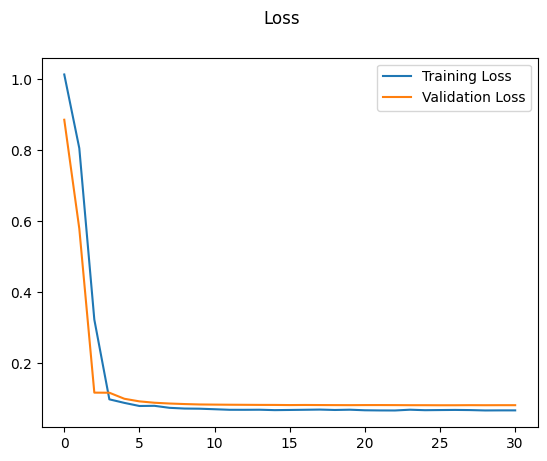

Result:

     Accuracy  F1 Score  Precision    Recall
559  0.981438  0.663163   0.993065  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       459
      Normal       0.98      1.00      0.99      3718
      Replay       0.00      0.00      0.00        79

    accuracy                           0.98      4256
   macro avg       0.66      0.67      0.66      4256
weighted avg       0.96      0.98      0.97      4256



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


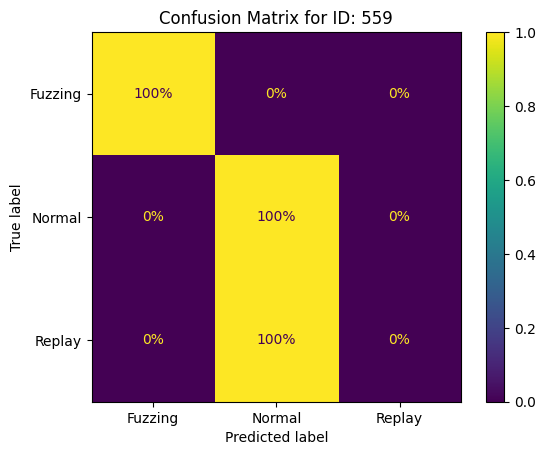

<Figure size 800x600 with 0 Axes>





Processing ID: 410
Epoch 1/100
21/21 [==============================] - 2s 34ms/step - loss: 0.8806 - accuracy: 0.7625 - val_loss: 0.5045 - val_accuracy: 0.8468
Epoch 2/100
21/21 [==============================] - 0s 13ms/step - loss: 0.2672 - accuracy: 0.9263 - val_loss: 0.1203 - val_accuracy: 0.9823
Epoch 3/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0904 - accuracy: 0.9875 - val_loss: 0.0982 - val_accuracy: 0.9841
Epoch 4/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0780 - accuracy: 0.9878 - val_loss: 0.0861 - val_accuracy: 0.9841
Epoch 5/100
21/21 [==============================] - 0s 14ms/step - loss: 0.0721 - accuracy: 0.9878 - val_loss: 0.0829 - val_accuracy: 0.9841
Epoch 6/100
21/21 [==============================] - 0s 12ms/step - loss: 0.0686 - accuracy: 0.9878 - val_loss: 0.0825 - val_accuracy: 0.9841
Epoch 7/100
21/21 [==============================] - 0s 12ms/step - loss: 0.0688 - accuracy: 0.9878 - val_loss: 0.0813 - val_

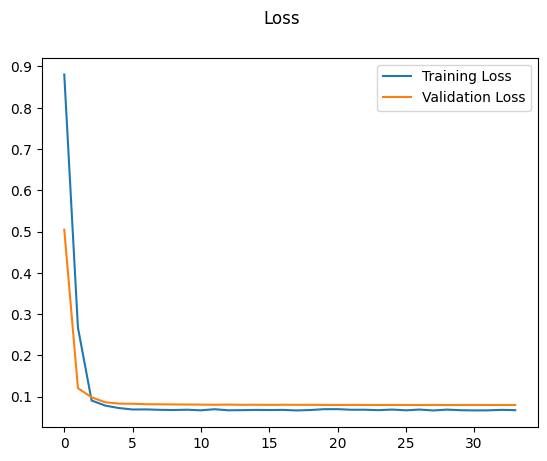

Result:

     Accuracy  F1 Score  Precision    Recall
410   0.98178   0.66317   0.993079  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       531
      Normal       0.98      1.00      0.99      3726
      Replay       0.00      0.00      0.00        79

    accuracy                           0.98      4336
   macro avg       0.66      0.67      0.66      4336
weighted avg       0.96      0.98      0.97      4336



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


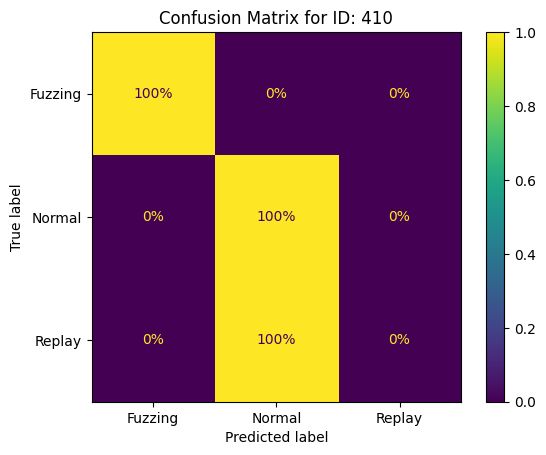

<Figure size 800x600 with 0 Axes>





Processing ID: 07F
Epoch 1/100
7/7 [==============================] - 2s 74ms/step - loss: 0.9017 - accuracy: 0.4310 - val_loss: 0.6928 - val_accuracy: 0.4684
Epoch 2/100
7/7 [==============================] - 0s 20ms/step - loss: 0.6591 - accuracy: 0.4483 - val_loss: 0.5594 - val_accuracy: 0.9914
Epoch 3/100
7/7 [==============================] - 0s 19ms/step - loss: 0.5892 - accuracy: 0.8042 - val_loss: 0.5239 - val_accuracy: 0.9914
Epoch 4/100
7/7 [==============================] - 0s 22ms/step - loss: 0.5525 - accuracy: 0.9914 - val_loss: 0.4821 - val_accuracy: 0.9914
Epoch 5/100
7/7 [==============================] - 0s 23ms/step - loss: 0.5012 - accuracy: 0.9926 - val_loss: 0.4177 - val_accuracy: 0.9914
Epoch 6/100
7/7 [==============================] - 0s 21ms/step - loss: 0.4221 - accuracy: 0.9926 - val_loss: 0.3235 - val_accuracy: 0.9914
Epoch 7/100
7/7 [==============================] - 0s 23ms/step - loss: 0.3132 - accuracy: 0.9926 - val_loss: 0.2141 - val_accuracy: 0.99

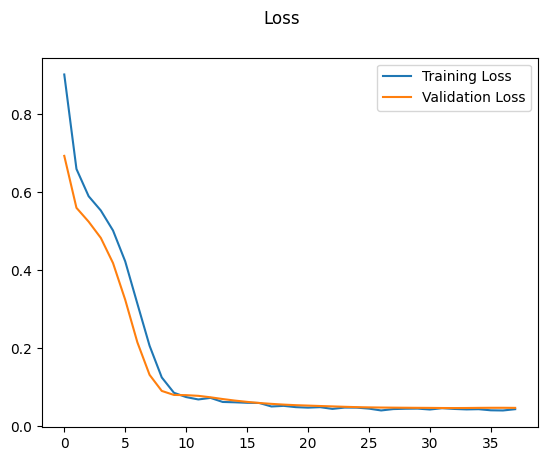

Result:

     Accuracy  F1 Score  Precision    Recall
07F  0.987597  0.663135    0.99301  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       527
      Normal       0.98      1.00      0.99       747
      Replay       0.00      0.00      0.00        16

    accuracy                           0.99      1290
   macro avg       0.66      0.67      0.66      1290
weighted avg       0.98      0.99      0.98      1290



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


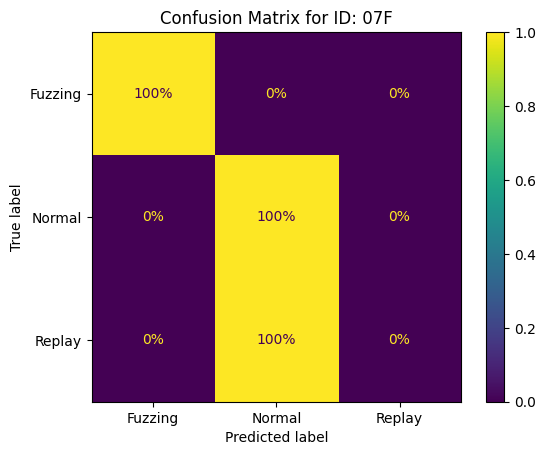

<Figure size 800x600 with 0 Axes>





Processing ID: 57F
Epoch 1/100
5/5 [==============================] - 2s 90ms/step - loss: 1.0710 - accuracy: 0.4408 - val_loss: 1.0287 - val_accuracy: 0.3765
Epoch 2/100
5/5 [==============================] - 0s 22ms/step - loss: 1.0024 - accuracy: 0.4930 - val_loss: 0.9473 - val_accuracy: 0.6842
Epoch 3/100
5/5 [==============================] - 0s 21ms/step - loss: 0.9181 - accuracy: 0.5279 - val_loss: 0.8429 - val_accuracy: 0.6842
Epoch 4/100
5/5 [==============================] - 0s 28ms/step - loss: 0.8295 - accuracy: 0.5575 - val_loss: 0.7428 - val_accuracy: 0.6842
Epoch 5/100
5/5 [==============================] - 0s 29ms/step - loss: 0.7574 - accuracy: 0.5749 - val_loss: 0.6767 - val_accuracy: 0.6842
Epoch 6/100
5/5 [==============================] - 0s 20ms/step - loss: 0.7237 - accuracy: 0.5697 - val_loss: 0.6518 - val_accuracy: 0.6842
Epoch 7/100
5/5 [==============================] - 0s 21ms/step - loss: 0.7180 - accuracy: 0.5697 - val_loss: 0.6520 - val_accuracy: 0.68

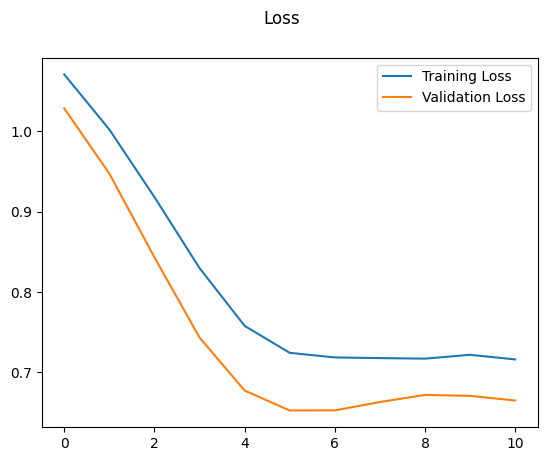

Result:

     Accuracy  F1 Score  Precision    Recall
57F  0.579418   0.24457   0.859806  0.333333

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       0.58      1.00      0.73       518
      Normal       0.00      0.00      0.00       369
      Replay       0.00      0.00      0.00         7

    accuracy                           0.58       894
   macro avg       0.19      0.33      0.24       894
weighted avg       0.34      0.58      0.43       894



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


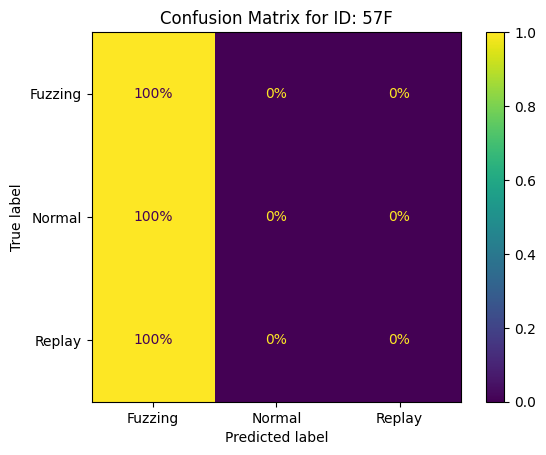

<Figure size 800x600 with 0 Axes>





Processing ID: 5B0
Epoch 1/100
7/7 [==============================] - 2s 76ms/step - loss: 1.0525 - accuracy: 0.7365 - val_loss: 0.9453 - val_accuracy: 0.9914
Epoch 2/100
7/7 [==============================] - 0s 22ms/step - loss: 0.9251 - accuracy: 0.9926 - val_loss: 0.7734 - val_accuracy: 0.9914
Epoch 3/100
7/7 [==============================] - 0s 20ms/step - loss: 0.7709 - accuracy: 0.9926 - val_loss: 0.5762 - val_accuracy: 0.9914
Epoch 4/100
7/7 [==============================] - 0s 21ms/step - loss: 0.6182 - accuracy: 0.9926 - val_loss: 0.4356 - val_accuracy: 0.9914
Epoch 5/100
7/7 [==============================] - 0s 19ms/step - loss: 0.4964 - accuracy: 0.9926 - val_loss: 0.3343 - val_accuracy: 0.9914
Epoch 6/100
7/7 [==============================] - 0s 20ms/step - loss: 0.3676 - accuracy: 0.9926 - val_loss: 0.2179 - val_accuracy: 0.9914
Epoch 7/100
7/7 [==============================] - 0s 22ms/step - loss: 0.2174 - accuracy: 0.9926 - val_loss: 0.1060 - val_accuracy: 0.99

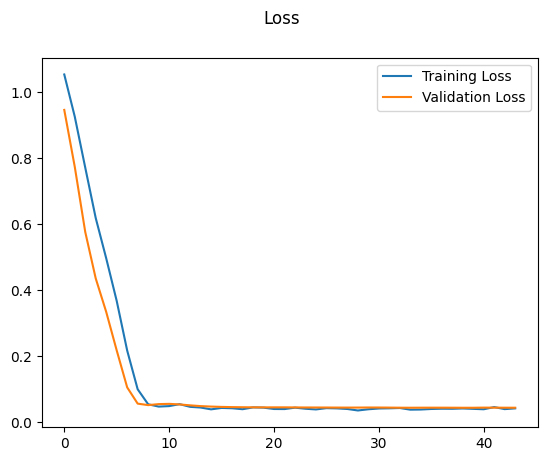

Result:

     Accuracy  F1 Score  Precision    Recall
5B0  0.988057   0.66334   0.993412  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       497
      Normal       0.98      1.00      0.99       744
      Replay       0.00      0.00      0.00        15

    accuracy                           0.99      1256
   macro avg       0.66      0.67      0.66      1256
weighted avg       0.98      0.99      0.98      1256



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


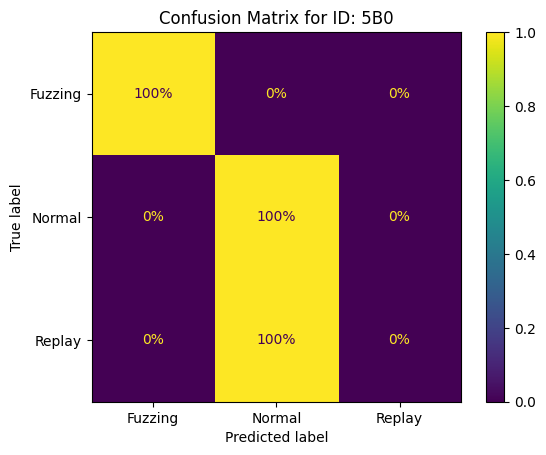

<Figure size 800x600 with 0 Axes>

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

id_total_results = pd.DataFrame()

for data_id in ids:
    print(f"Processing ID: {data_id}")
    X_train, X_test, y_train, y_test, class_labels = id_train_test_set(dfs_by_id_train, dfs_by_id_test, data_id)
    y_pred = model_train(X_train, X_test, y_train, y_test, class_labels)
    evaluation_results={}

    # 각 모델에 대해 예측을 수행하고 평가 지표를 계산
    # Acccuracy, precision, recall, f1-score 계산
    modelAcc_1= accuracy_score(y_test, y_pred)
    precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, average='macro', zero_division=1.0)

    # 결과를 딕셔너리에 저장
    evaluation_results[data_id] = {
        'Accuracy': modelAcc_1,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score
    }

    print('Result:\n')
    print(pd.DataFrame(evaluation_results).T)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_labels))

    # 혼동 행렬 계산 및 시각화
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=class_labels, normalize='true', values_format='.0%')

    # 시각화
    plt.title(f'Confusion Matrix for ID: {data_id}')
    #disp.plot(cmap=plt.cm.Blues)
    plt.figure(figsize=(8, 6))
    #cm = confusion_matrix(y_test, y_pred)
    plt.show()
    print("\n" + "="*80 + "\n")

    # 각 아이디별, 모델별 결과 저장
    id_total_results = pd.concat([id_total_results, pd.DataFrame(evaluation_results)], axis=1)
    print("\n" + "="*80 + "\n")

### 모든 ID들의 성능의 평균치 계산
- Accuracy, F1-score, Precision의 평균 계산

In [ ]:
id_total_results

,251,2B0,381,340,260,47F,329,164,387,394,...,4A2,50A,043,52A,544,559,410,07F,57F,5B0
Accuracy,0.979334,0.979616,0.979563,0.979482,0.999987,0.979557,0.979399,0.979612,0.976477,0.979538,...,0.984260,0.984364,0.993096,0.986878,0.979355,0.981438,0.981780,0.987597,0.579418,0.988057
F1 Score,0.659547,0.663187,0.662539,0.663188,0.999826,0.662517,0.661867,0.663187,0.741338,0.662811,...,0.663121,0.661490,0.843498,0.664342,0.659444,0.663163,0.663170,0.663135,0.244570,0.663340
Precision,0.992085,0.993112,0.993095,0.993115,0.999996,0.993096,0.993087,0.993113,0.780321,0.993099,...,0.992982,0.994257,0.994730,0.995383,0.992209,0.993065,0.993079,0.993010,0.859806,0.993412
Recall,0.660457,0.666667,0.665392,0.666667,0.999656,0.665347,0.664062,0.666667,0.721368,0.665929,...,0.666667,0.662136,0.789474,0.666667,0.660169,0.666667,0.666667,0.666667,0.333333,0.666667


In [ ]:
id_total_results.mean(axis='columns')

Accuracy     0.952117
F1 Score     0.647139
Precision    0.973972
Recall       0.657867
dtype: float64

In [ ]:
output_file = '/content/drive/MyDrive/CAN/submit_filter_data/ANN_performance_scores_by_id_v2_macro.csv'
id_total_results.to_csv(output_file, index=False)